# Spritz MBHB search + imputation (time-domain approach)

Let's try to  replicate `MBHB-search-dev-globe.ipynb` with time-domain data and with Spritz data (MBHB-1 dataset).

E Castelli - 2022

## Table of contents

0. Settings and package import
1. Load time-domain LDC data
2. Build orthogonal TDI combinations
3. Data pre-processing before gap-imputation
4. Gap imputation with custom gaps
    1. noise-only `n` data
    2. noise + signal `n + s` data
5. Analysis of Spritz data

## 0. Settings and package import

In [1]:
# Python standard packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from cycler import cycler
import scipy.signal
import h5py
import time
import sys
from pyfftw.interfaces.numpy_fft import fft, ifft
from scipy import interpolate
from scipy import optimize



In [2]:
# Custom LISA Data Analysis packages 
from ldc.lisa.noise import get_noise_model
from ldc.common.tools import window

import lisabeta.lisa.ldcnoise as ldcnoise
from bayesdawn import datamodel, psdmodel
import lisaorbits

MLDC modules could not be loaded.


In [3]:
# define function to print all attributes of hdf5 file recursively
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. In order to do that, we separate the effect of glitches from the effect of gaps in the Spritz data.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [4]:
# import data
fname = '../data/LDC2_spritz_mbhb1_training_v2.h5'
# open file with h5py
fid = h5py.File(fname)
# print all dataset attributes
# fid.visititems(print_attrs)
cfg = dict(zip(fid["obs/config"].keys(), [v[()] for v in fid["obs/config"].values()]))

#### 1.1. Import LDC data
Import the existing TDI datasets and build the missing TDI dataset

Existing:
- TDI dataset `obs` containing `noise + signal + artifacts` (gaps + glitches)
- TDI dataset `clean` containing `noise + signal`
- TDI dataset `sky` containing `signal`
- TDI dataset `noisefree` containing `signal + artifacts` (gaps + glitches)

Missing:
- TDI dataset containing `noise`
- TDI dataset containing `noise + signal + gaps`

In [5]:
from bayesdawn.connect.fillgaps import load_tdi_timeseries

In [6]:
tdidata = load_tdi_timeseries(fname = fname)

In [7]:
# set up dataset constant values

skip = 0 # number of samples to skip
ndata = len(tdidata['obs'][:]) # length of dataset
dt = tdidata['obs']['t'][1]-tdidata['obs']['t'][0] # time step
tobs = ndata * dt # observation time
fs = 1.0/dt # sampling frequency
fmin = np.round(1.0/(tobs),9)+2e-9 # minumum frequency


print('skip','ndata','dt', 'fs', 'tobs\t', 'fmin', sep='\t',end='\n'+60*'-'+'\n')
print(skip, ndata, dt, fs, tobs, fmin, sep='\t')

skip	ndata	dt	fs	tobs		fmin
------------------------------------------------------------
0	535680	5.0	0.2	2678400.0	3.75e-07


#### 1.3. Plot imported data:
- Datasets containing NO noise artifacts: `n+s`, `s`, `n`
- Dataset with artifacts: `n+s+g+gl`, `n+s+g`,`s+g+gl`
    
Useful LDC-provided resources and code bits to importing Spritz data taken from here: https://gitlab.in2p3.fr/LISA/LDC/-/blob/develop/notebooks/LDC2b-Spritz.ipynb

In [8]:
nperseg = fs/1e-5
avgwin = 'boxcar'

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

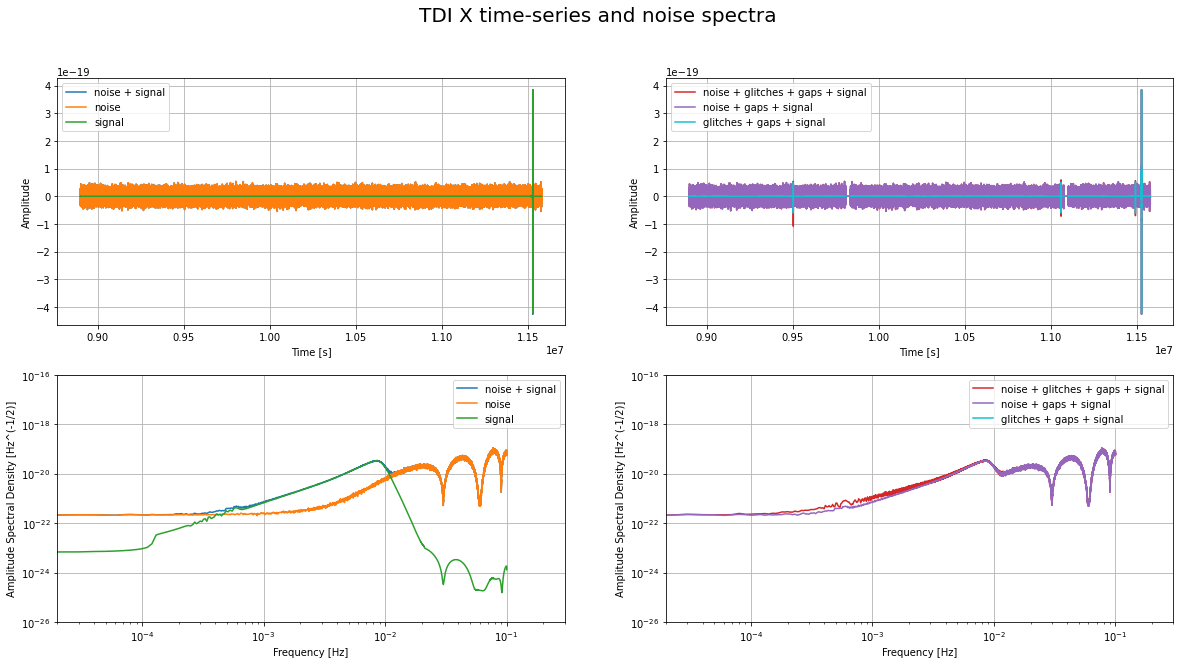

In [9]:
# plot TDI X time-series and noise spectra for all different configurations

fig, ax = plt.subplots(2, 2, figsize=(20,10))
# top left canvas
ax[0][0].plot(tdidata['clean']['t'][skip:], tdidata['clean']["X"][skip:], label = 'noise + signal')
ax[0][0].plot(tdidata['noise']['t'][skip:], tdidata['noise']["X"][skip:], label='noise')
ax[0][0].plot(tdidata['sky']['t'][skip:], tdidata['sky']["X"][skip:], label='signal')
ax[0][0].set_ylabel("Amplitude")
ax[0][0].set_xlabel("Time [s]")
ax[0][0].grid()
ax[0][0].legend()
# top right canvas
ax[0][1].plot(tdidata['obs']['t'][skip:], tdidata['obs']["X"][skip:], label='noise + glitches + gaps + signal', color='tab:red')
ax[0][1].plot(tdidata['clean_gapped']['t'][skip:], tdidata['clean_gapped']["X"][skip:], label='noise + gaps + signal', color='tab:purple')
ax[0][1].plot(tdidata['noisefree']['t'][skip:], tdidata['noisefree']["X"][skip:], label='glitches + gaps + signal', color='tab:cyan')
ax[0][1].set_ylabel("Amplitude")
ax[0][1].set_xlabel("Time [s]")
ax[0][1].grid()
ax[0][1].legend()
# bottom left canvas
f, psdX =  scipy.signal.welch(tdidata['clean']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise + signal')
f, psdX =  scipy.signal.welch(tdidata['noise']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise')
f, psdX =  scipy.signal.welch(tdidata['sky']["X"][skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'signal')
ax[1][0].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][0].set_xlabel("Frequency [Hz]")
ax[1][0].grid()
ax[1][0].legend()
ax[1][0].set_ylim([1e-26,1e-16])
ax[1][0].set_xlim([2e-5,0.3])

# bottom right canvas
tdix_wo_nan = tdidata['obs']["X"].copy()
tdix_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdix_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + glitches + gaps + signal', color='tab:red')

tdigapped_wo_nan = tdidata['clean_gapped']["X"].copy()
tdigapped_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdigapped_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + gaps + signal', color='tab:purple')

tdinoise_wo_nan = tdidata['noisefree']["X"].copy()
tdinoise_wo_nan[np.isnan(tdidata['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdinoise_wo_nan[skip:], fs=1.0/dt, window=avgwin, nperseg=nperseg)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'glitches + gaps + signal', color='tab:cyan')

ax[1][1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][1].set_xlabel("Frequency [Hz]")
ax[1][1].grid()
ax[1][1].legend()
ax[1][1].set_ylim([1e-26,1e-16])
ax[1][1].set_xlim([2e-5,0.3])

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)
# fig.tight_layout()

## 2. Build orthogonal TDI combinations

### 2.1. Build orthogonal TDI combinations for `n+s` data. 

Check that explicit evaluation of orthogonal TDI combinations is equivalent to evaluation inside LDC functions.

In [10]:
from bayesdawn.connect.fillgaps import build_orthogonal_tdi

In [11]:
datans = build_orthogonal_tdi(tdidata['clean'])

Compare my evaluation to LDC conversion function, just to be on the safe side of things.

### 2.2. Build orthogonal TDI combinations for `s`, `n`, `n+s+g` data. 


In [12]:
datas  = build_orthogonal_tdi(tdidata['sky'])
datan  = build_orthogonal_tdi(tdidata['noise'])
datag  = build_orthogonal_tdi(tdidata['clean_gapped'])
datang = build_orthogonal_tdi(tdidata['noise_gapped'])
dataobs = build_orthogonal_tdi(tdidata['obs'])

### 2.3. Define useful functions 

All these will end up in a separate file afterwards.

- `fft_olap_psd`: function that evaluates PSD equivalent to `scipy.signal.welch` and also evaluates FFT at the same time
- `generate_freq_data`: function that applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
- `plot_compare_spectra_timeseries`: modified version of `lisabeta_fill_gaps.plot_compare_spectra` function that plots noise spectra and distribution of real/imag part of PSD/noise_model

### 2.4 Data quicklook
#### 2.4.1 Test PSD and FFT evaluation function

In [13]:
from bayesdawn.connect.fillgaps import fft_olap_psd, generate_freq_data, plot_compare_spectra_timeseries

#### 2.4.2 Define LISA noise model
Import noise model for Spritz data from LDC toolbox.

In [14]:
cfg['dt_orbits'], cfg['nominal_arm_length'], cfg['kepler_order']

(86400.0, 2500000000.0, 2)

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/bayesdawn-0.1.0-py3.10.egg/bayesdawn/connect/fillgaps.py:508: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


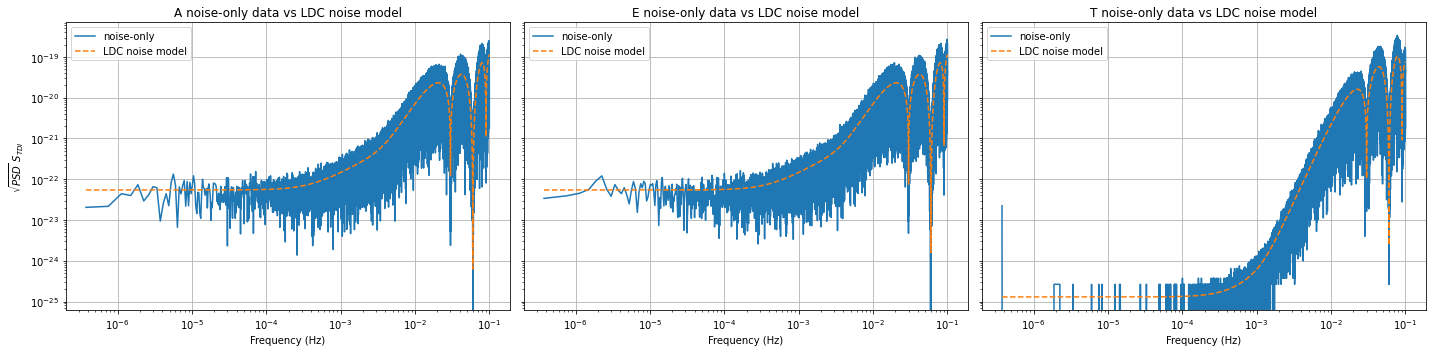

In [15]:
#Load some noise models from lisabeta
# import lisabeta.lisa.pyLISAnoise as pyLISAnoise

LISAnoise={'InstrumentalNoise': 'SciRDv1', 
           'WDbackground': False, 
           'WDduration': 0.0, 
           'lowf_add_pm_noise_f0': 0.0, 
           'lowf_add_pm_noise_alpha': 2.0}
# LISAnoise={'InstrumentalNoise': 'Proposal', 
#            'WDbackground': True, 
#            'WDduration': 3.0, 
#            'lowf_add_pm_noise_f0': 0.0, 
#            'lowf_add_pm_noise_alpha': 2.0}

# eval psd of noise data
fdatan, psddatan, fftscalefac = generate_freq_data(datan, fmin = fmin, win='hanning')
# noise models for A, E, T
 # Comparison with LISA Orbits
orbits = lisaorbits.KeplerianOrbits(dt=cfg['dt_orbits'], 
                                    L=cfg['nominal_arm_length'], 
                                    a=149597870700.0, 
                                    lambda1=0, 
                                    m_init1=0, 
                                    kepler_order=cfg['kepler_order'])
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan['f'], wd=0, orbits=orbits, t_obs=ndata*dt)
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan['f'], equal_arms=False)
# plot data
fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=True)
for tdi in S.keys(): 
    ax[list(S.keys()).index(tdi)].set_title('{tdi} noise-only data vs LDC noise model'.format(tdi=tdi))
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(psddatan[tdi]), label='noise-only')
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(S[tdi]), ls='--', label='LDC noise model')
    ax[list(S.keys()).index(tdi)].set_xlabel('Frequency (Hz)')
    ax[list(S.keys()).index(tdi)].grid()
    ax[list(S.keys()).index(tdi)].legend()

ax[0].set_ylabel(r'$\sqrt{PSD}$ $S_{TDI}$')
fig.tight_layout()
# plt.suptitle('Comparison between TDI of noise-only Spritz data vs noise models');

#### 2.4.3 Plot comparison between spectra and FFT distribution

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


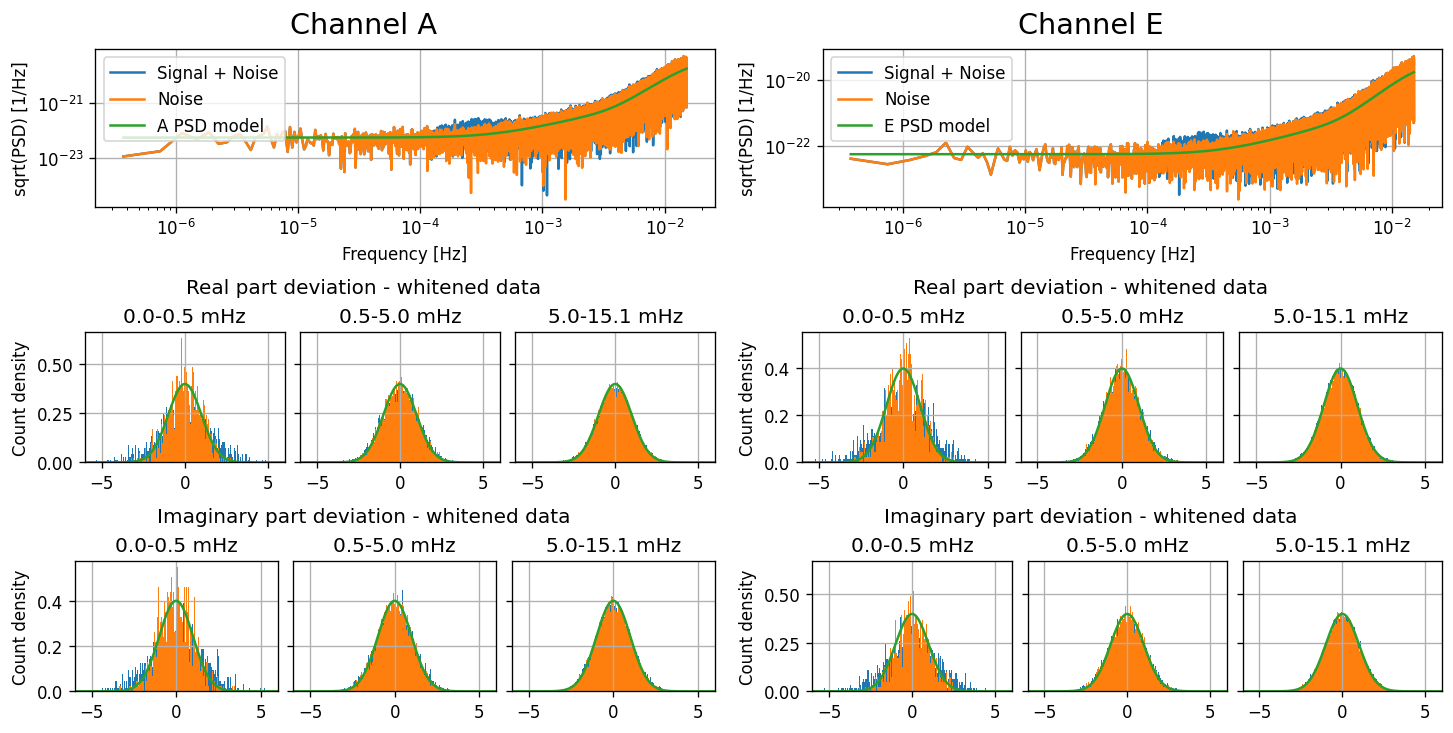

In [16]:
fmax = 1.51e-2
plot_compare_spectra_timeseries(data = [datans, datan], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = fmax)

## 3. Spritz data gaps in noise only data `n + g`

In [17]:
# import lisabeta_fill_gaps as fill_gaps
from bayesdawn.connect.fillgaps import construct_gap_mask

Here we compare the full noise + signal dataset with the only-noise dataset, applying `LISAnoise` as noise model for the TDI noise spectra.

We'll first apply imputation to noise-only `n` data in the `datan` dataset.

For gapped data we'll be using the `datang` dataset, containing the Sprtiz noise-only data with gaps `n + g`.


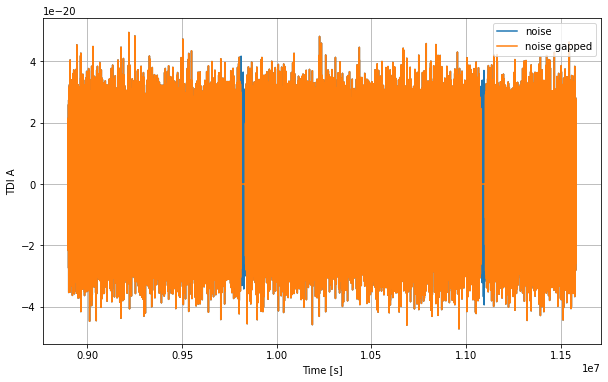

In [18]:
# compare noise full data and noise gapped data
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# top left canvas
ax.plot(datan['t'], datan['A'], label='noise')
ax.plot(datang['t'], datang['A'], label='noise gapped')
ax.set_xlabel('Time [s]')
ax.set_ylabel('TDI A')
ax.grid()
ax.legend()

In [19]:
# reset time-series information data
ndata = datang.shape[0]
dt = datang['t'][1]-datang['t'][0]
fs = 1/(datang['t'][1]-datang['t'][0])

print('ndata','dt', 'fs',sep='\t',end='\n---------------------\n')
print(ndata, dt, fs,sep='\t')

fdatan, psddatan, fftscalefac = generate_freq_data(datan)
fdatang, psddatang, fftscalefac = generate_freq_data(datang)

ndata	dt	fs
---------------------
535580	5.0	0.2


### 3.1 Set up PSD Spritz noise model

We'll end up not using this noise model in the gap imputation, but this might be useful for other purposes (or once the Spritz noise model is fixed).

In [20]:
from bayesdawn.connect.fillgaps import LDCModelPSD

Let's take a look at the model w.r.t downaveraged data.

We also need to generate the Spritz gap mask.

In [21]:
from bayesdawn.connect.fillgaps import get_ldc_gap_mask

In [22]:
mask = np.ones(datang.shape[0])
ndata = datang.shape[0]

spritzgaps = get_ldc_gap_mask(dataobs, mode='index')
gapstarts,gapends= np.vsplit(spritzgaps, 2)

for k in range(gapstarts.shape[1]):
    mask[gapstarts.reshape((2))[k]:gapends.reshape((2))[k]]=0

spritzmask = {'mask': mask,
              'starts': gapstarts.reshape((2)),
              'ends': gapends.reshape((2))}

figname = 'figures/nodownavg_spritzgaps'

Text(0, 0.5, 'Spritz gap mask')

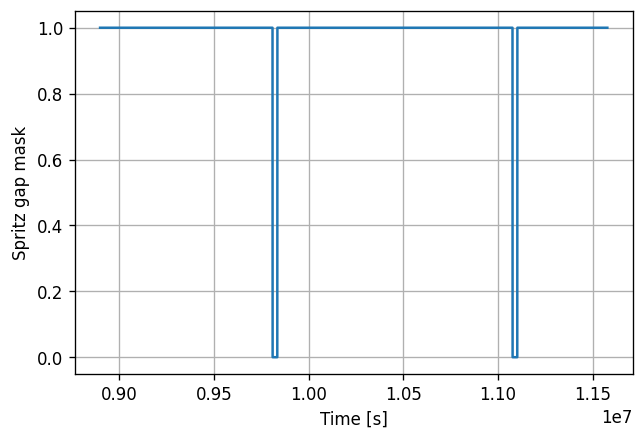

In [23]:
fig,ax = plt.subplots(1,1,dpi=120)
# ax.plot(maskinfo['mask'])
ax.plot(datan['t'],spritzmask['mask'])
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Spritz gap mask')

### 3.2 Visualize gaps in time-domain

Slightly modified version of `lisabeta_fill_gaps.view_gaps`.

In [24]:
from bayesdawn.connect.fillgaps import view_gaps

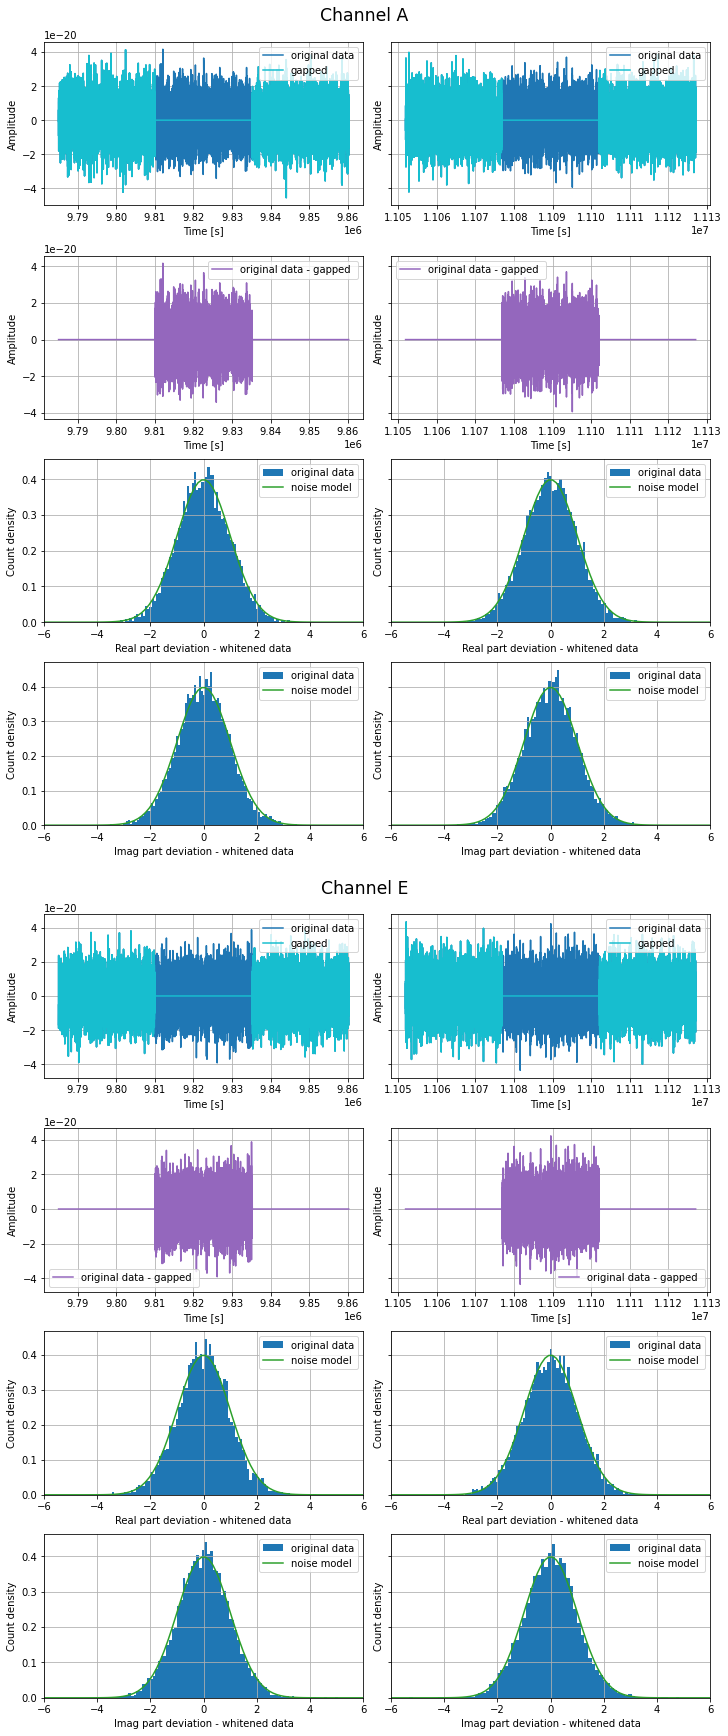

In [25]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datang.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data'], nwing = 5000, histogram=True)

### 3.3 Set up LDC noise model for PSD

In [26]:
# Embed the PSD function in a class
# psdmodel is imported from bayesdawn
class LDCModelPSD0(psdmodel.PSD):
    '''
    Specialization of the bayesdawn psd model class which connects LDC noise models to lisabeta PSD models.
    
    Parameters
    ----------
    n_data : array_like
        vector of size N_DSP continaing the noise DSP calculated at frequencies
        between -fe/N_DSP and fe/N_DSP where fe is the sampling frequency and N
        is the size of the time series (it will be the size of the returned
        temporal noise vector b)
    fs : scalar integer
        Size of the output time series
    noise_model : scalar float
        sampling frequency
    channel : string
        seed of the random number generator

    Returns
    -------
        bf : numpy array
        frequency sample of the colored noise (size N)
    '''

    def __init__(self, ndata, fs, noise_model, channel, fmin=None, fmax=None, config = cfg):
        # instantiates the PDS estimator from function psdmodel.PSD
        self.noise_model = noise_model
        self.channel = channel
        psdmodel.PSD.__init__(self, ndata, fs, fmin=None, fmax=None)
        if fmax is not None:
            self.f = self.f[self.f<fmax]

    def psd_fn(self, x):
        # returns the psd function defined earlier
        tobs = ndata / fs
        orbits = lisaorbits.KeplerianOrbits(dt=cfg['dt_orbits'], 
                                    L=cfg['nominal_arm_length'], 
                                    a=149597870700.0, 
                                    lambda1=0, 
                                    m_init1=0, 
                                    kepler_order=cfg['kepler_order']) 
        
        Nmodel = get_noise_model(self.noise_model, x, wd=0, orbits=orbits, t_obs=tobs)
        return Nmodel.psd(tdi2=True, option=self.channel, freq=x, equal_arms=False)

## 4. Perform data imputation with only LDC noise model

In [27]:
from bayesdawn.connect.fillgaps import create_imputation, update_imputation

In [28]:
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []

names=['A', 'E', 'T']
# set up flags and variables
mask = spritzmask['mask']
datang_rec = datang.copy()

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/bayesdawn-0.1.0-py3.10.egg/bayesdawn/datamodel.py:340: UserWarning: The maximum size of gap + conditional is high.


Computation of autocovariance + PSD took 7.626806974411011
Imputation for combination A took 7.820143222808838
Computation of autocovariance + PSD took 6.360059022903442
Imputation for combination E took 6.515156984329224
Computation of autocovariance + PSD took 7.349471092224121
Imputation for combination T took 7.532946825027466


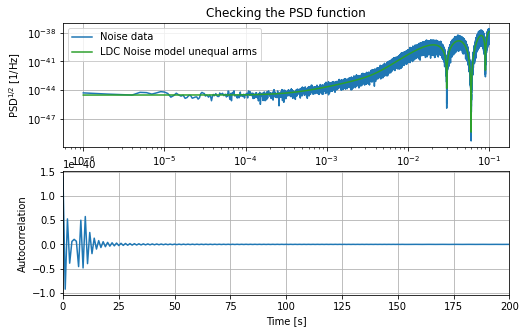

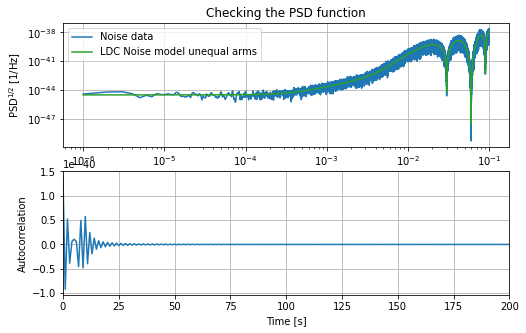

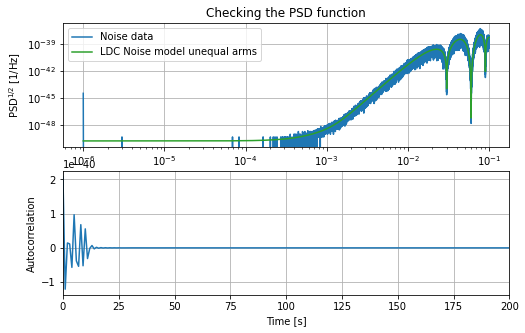

In [29]:
# Perform data imputation WITHOUT loop
### NB this can be streamlined a little bit more and/or transformed into a function 
for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))
    # Plot data against PSD
    fig, ax = plt.subplots(2, 1, figsize=(8,5))
    ax[0].set_title(r"Checking the PSD function")
    ax[0].set_xlabel(r"Frequency [Hz]")
    ax[0].set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax[0].loglog(psddatan['f'], (psddatan[tdi]), label="Noise data")
    ax[0].loglog(psddatan['f'], psd_cls.psd_fn(psddatan['f']), label="LDC Noise model unequal arms", color='tab:green')
    # ax.loglog(psddatang['f'], (psddatang['A']), label="Noise")
    ax[0].grid()
    ax[0].legend()
    # look at the psd autocorrelation to assess the width of the nearest region
    ax[1].plot(psd_cls.calculate_autocorr(ndata))
    ax[1].grid()
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Autocorrelation')
    ax[1].set_xlim([0, 200])

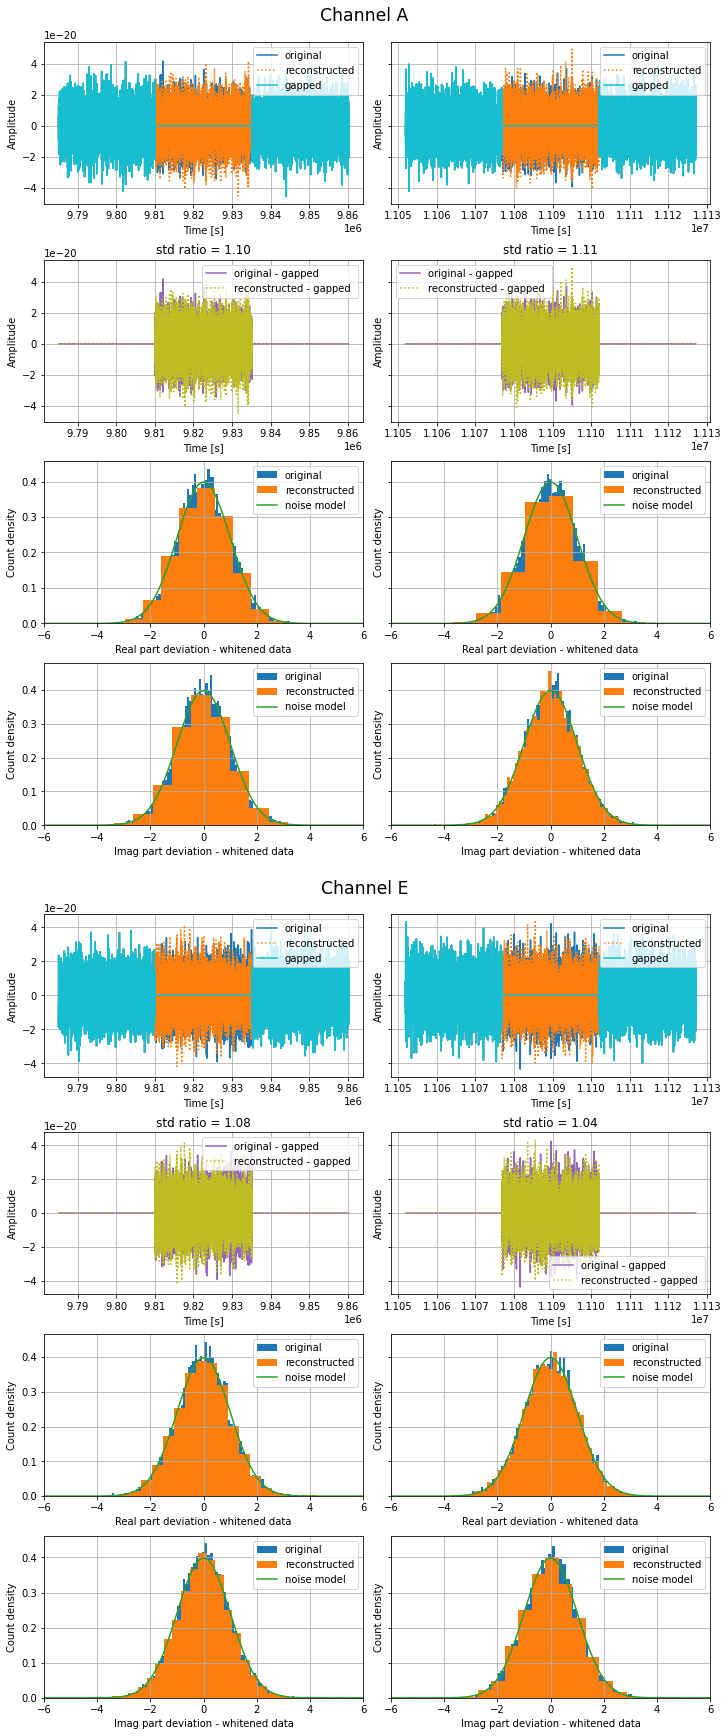

In [30]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original', 'reconstructed', 'gapped'],
          save = False, fname = figname, nwing=5000)

In [31]:
# fdatan_rec, psddata_rec, _ = generate_freq_data(datang_rec, fmin = fmin, win='boxcar') 

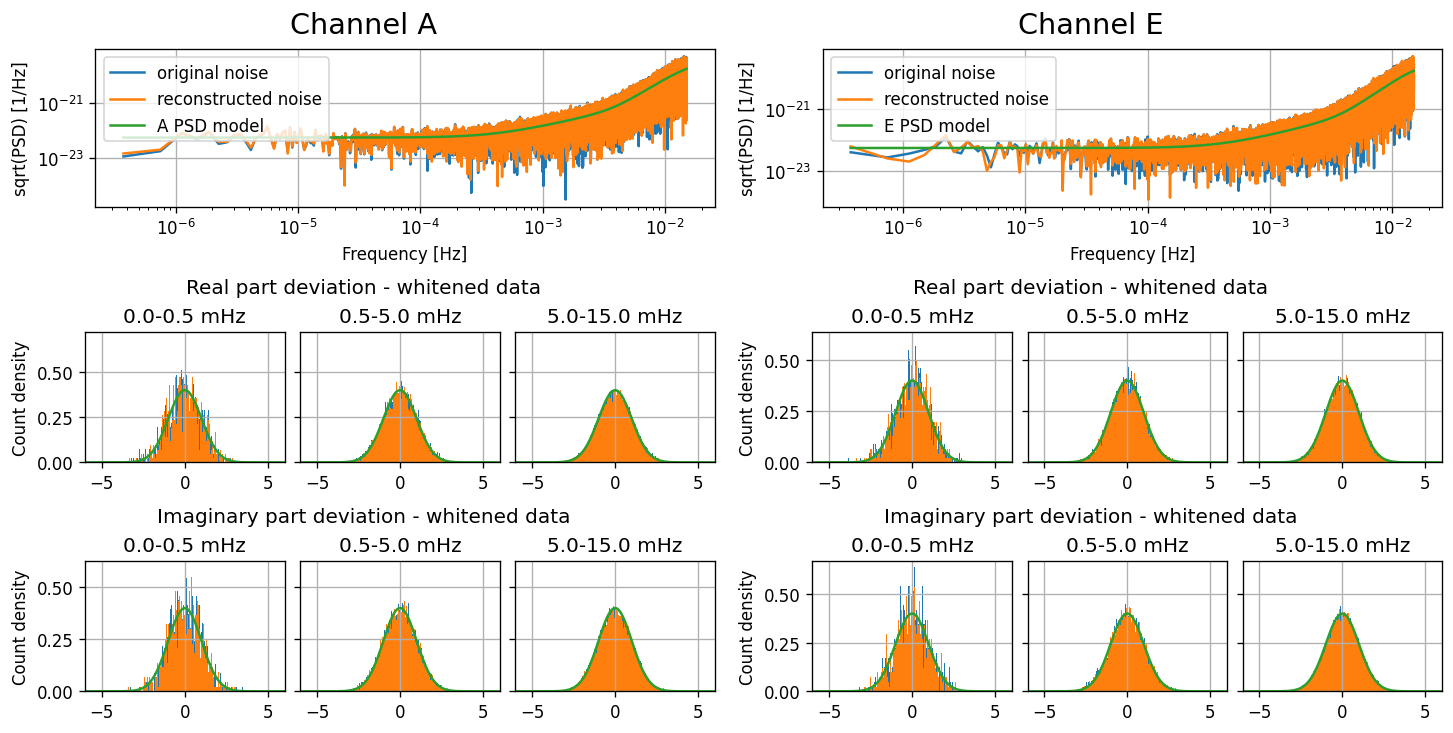

In [32]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec],
                                fmin = fmin, fmax = 1.5e-2, freq_bands=[5e-4, 5e-3],
                               labels = ['original noise', 'reconstructed noise'], 
                                save = False, fname = figname)

## 5. Perform data imputation with freq-domain PSD estimation

In [33]:
from bayesdawn import datamodel, psdmodel

### 5.1 Import PSD freq domain estimation tool
Import John's frequency domain PSD estimation tool.

In [34]:
import bayesdawn.connect.fillgaps as fillgaps
from bayesdawn.connect.fillgaps import makeFDdata


### 5.2 PSD estimated with `fit_type=None`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 6.429929971694946
Computation of autocovariance + PSD took 0.22162270545959473
Computation of autocovariance + PSD took 0.21008801460266113
Computation of autocovariance + PSD took 0.2019031047821045
Computation of autocovariance + PSD took 0.20025205612182617
Computation of autocovariance + PSD took 0.20240092277526855
Computation of autocovariance + PSD took 0.2147970199584961
Imputation for combination A took 12.398327112197876
Computation of autocovariance + PSD took 6.882352113723755
Computation of autocovariance + PSD took 0.21057415008544922
Computation of autocovariance + PSD took 0.20465373992919922
Computation of autocovariance + PSD took 0.19771432876586914
Computation of autocovariance + PSD took 0.19765877723693848
Computation of autocovariance + PSD took 0.20566725730895996
Computation of autocovariance + PSD took 0.20263099670410156
Imputation for combination E took 12.78526496887207


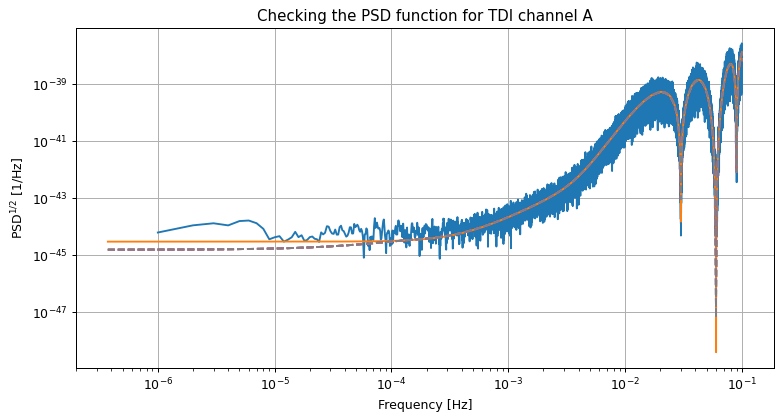

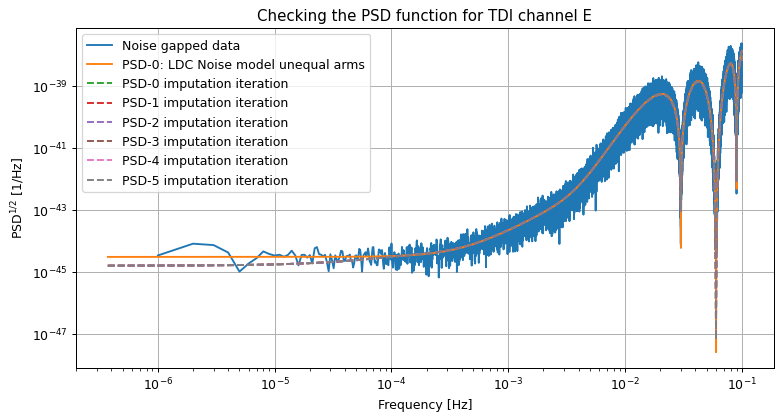

In [35]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names = ['A', 'E']
mask = spritzmask['mask']
# imputation settings
n_iter = 6
fit_type = None
fit_dof = 6
k = 1
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))


## initialize imputation
for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise gapped data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="PSD-0: LDC Noise model unequal arms")
    ax.grid()

    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        
        ax.loglog(psdmod.f[psdmod.f>0], (psdmod.psd_fn(psdmod.f[psdmod.f>0])), ls='--', 
                  label='PSD-'+str(i)+' imputation iteration')
        
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='upper left')
ax.grid()

ax.grid()

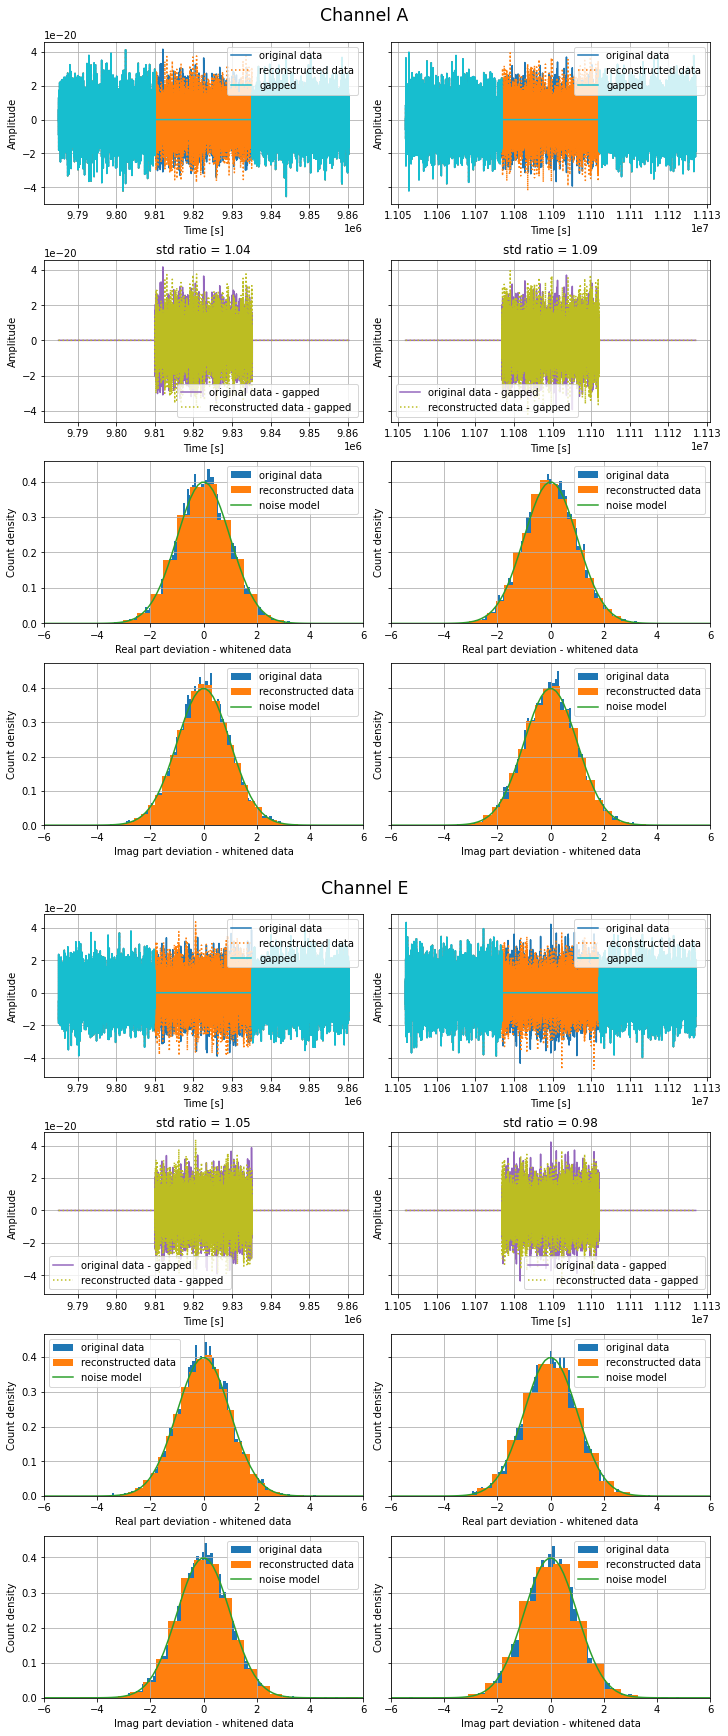

In [36]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

In [37]:
fmin

3.75e-07

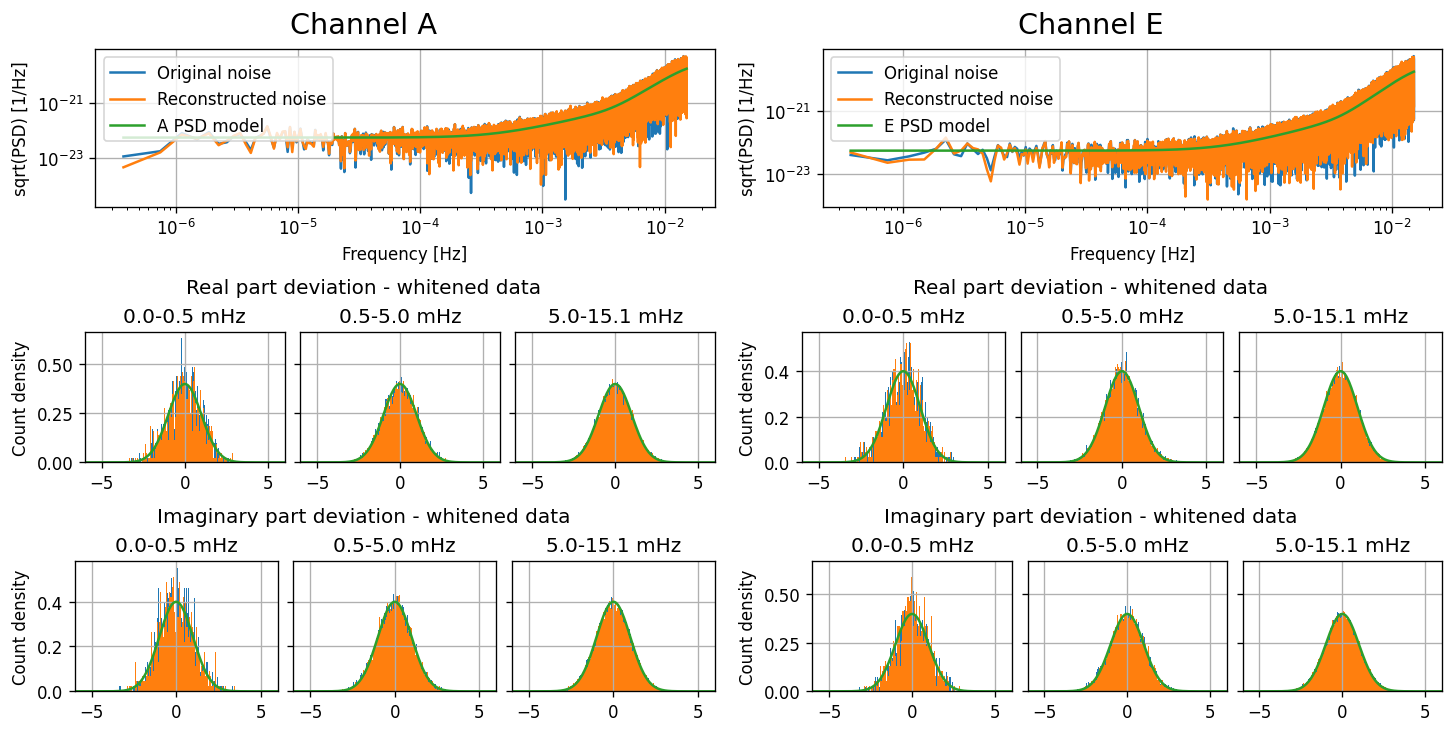

In [38]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin=fmin, fmax = 1.51e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

### 5.3 PSD estimated with `fit_type='log_spline`
#### Test 1: `fit_dof=6`, `k_fmin = 1`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 6.8732380867004395
Computation of autocovariance + PSD took 0.26442718505859375
Computation of autocovariance + PSD took 0.22565412521362305
Computation of autocovariance + PSD took 0.25899410247802734
Computation of autocovariance + PSD took 0.23348593711853027
Computation of autocovariance + PSD took 0.245894193649292
Computation of autocovariance + PSD took 0.21979808807373047
Computation of autocovariance + PSD took 0.24268198013305664
Computation of autocovariance + PSD took 0.2613849639892578
Computation of autocovariance + PSD took 0.23482704162597656
Computation of autocovariance + PSD took 0.22755885124206543
Imputation for combination A took 16.226350784301758
Computation of autocovariance + PSD took 6.482754707336426
Computation of autocovariance + PSD took 0.23231720924377441
Computation of autocovariance + PSD took 0.2514188289642334
Computation of autocovariance + PSD took 0.24761700630187988
Computation o

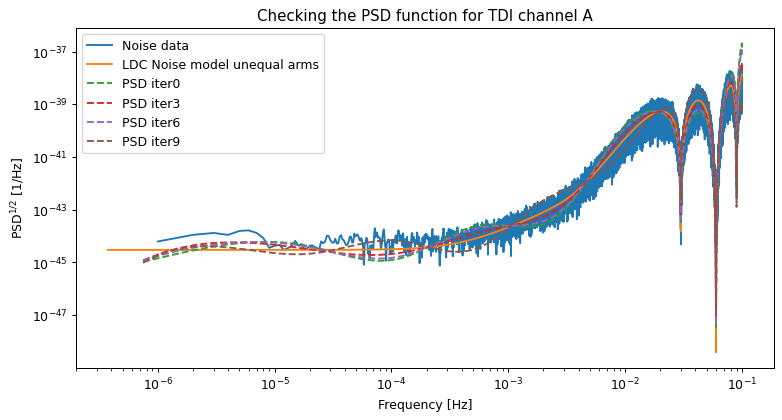

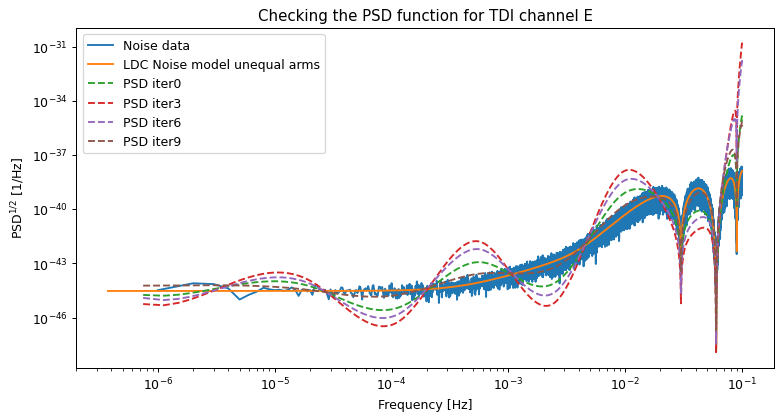

In [39]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 6
k = 1

fmin_fit = 1 / tobs * k

print(' `fmin` value is {:.2e}'.format(fmin))

# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))
    ax.legend(loc='best')
    ax.grid()

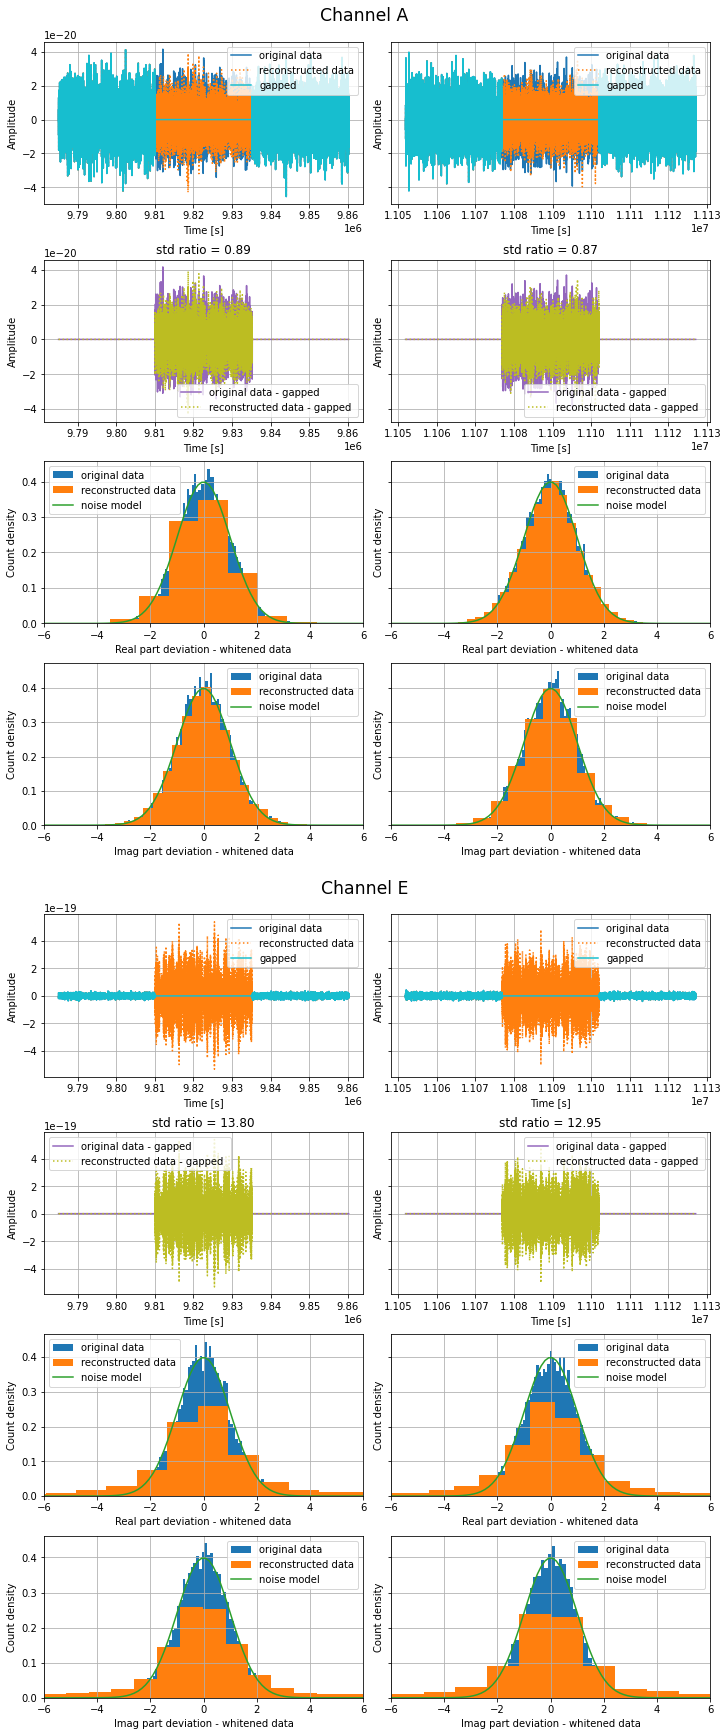

In [40]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

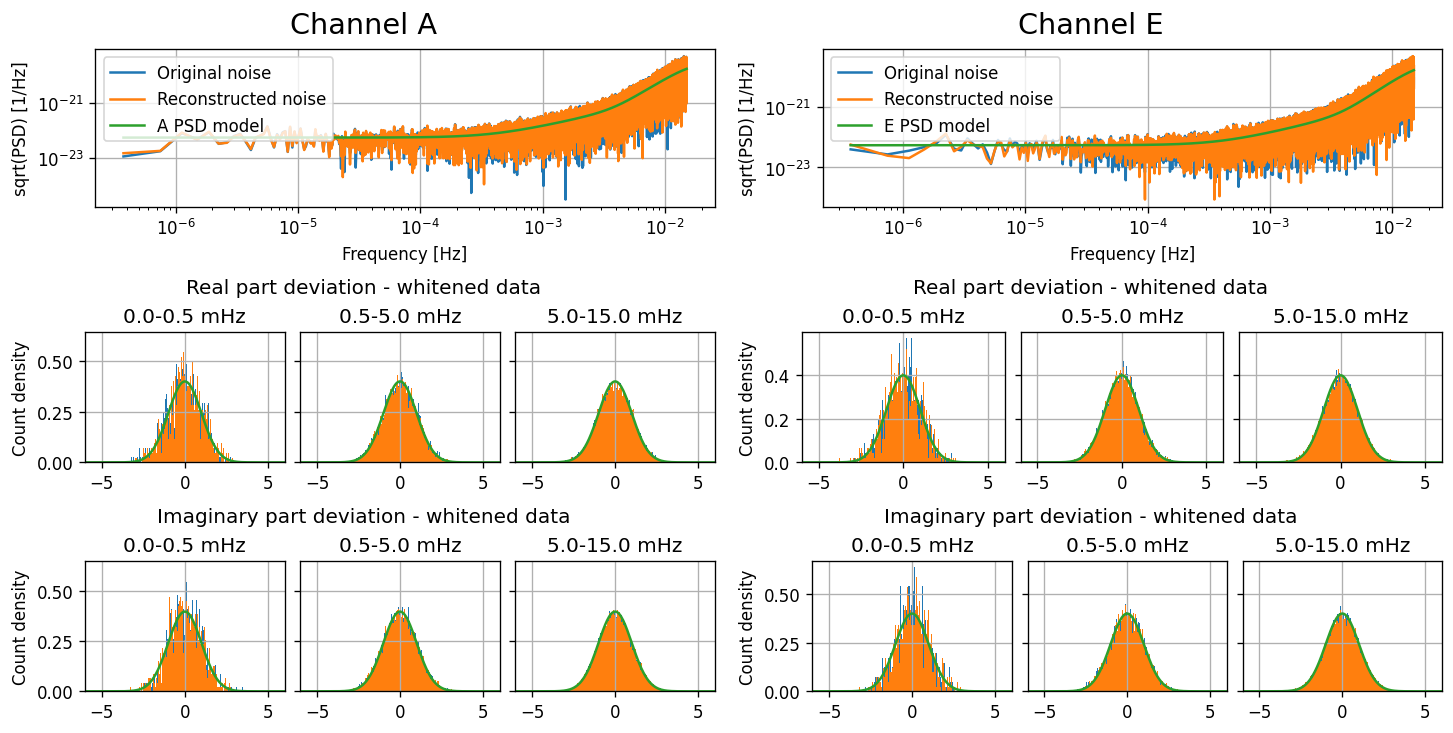

In [41]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 2: `fit_dof=15`, `k_fmin = 1`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 6.705423831939697
Computation of autocovariance + PSD took 0.25649285316467285
Computation of autocovariance + PSD took 0.23952007293701172
Computation of autocovariance + PSD took 0.22527003288269043
Computation of autocovariance + PSD took 0.2513740062713623
Computation of autocovariance + PSD took 0.27240705490112305
Computation of autocovariance + PSD took 0.24588632583618164
Computation of autocovariance + PSD took 0.24309492111206055
Computation of autocovariance + PSD took 0.25435805320739746
Computation of autocovariance + PSD took 0.24288296699523926
Computation of autocovariance + PSD took 0.23038220405578613
Imputation for combination A took 16.144596099853516
Computation of autocovariance + PSD took 6.643165111541748
Computation of autocovariance + PSD took 0.2408308982849121
Computation of autocovariance + PSD took 0.24285101890563965
Computation of autocovariance + PSD took 0.22562384605407715
Computation 

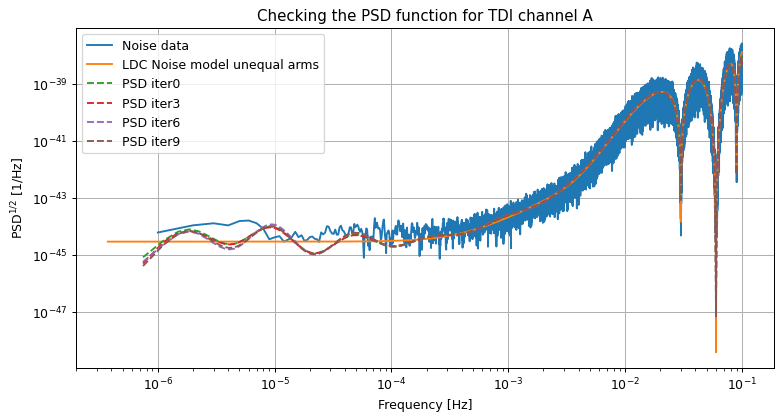

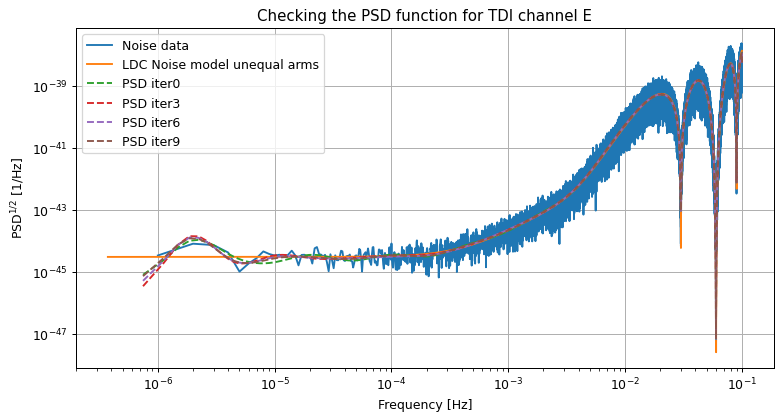

In [42]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 15
k = 1
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))

## initialize imputation

for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

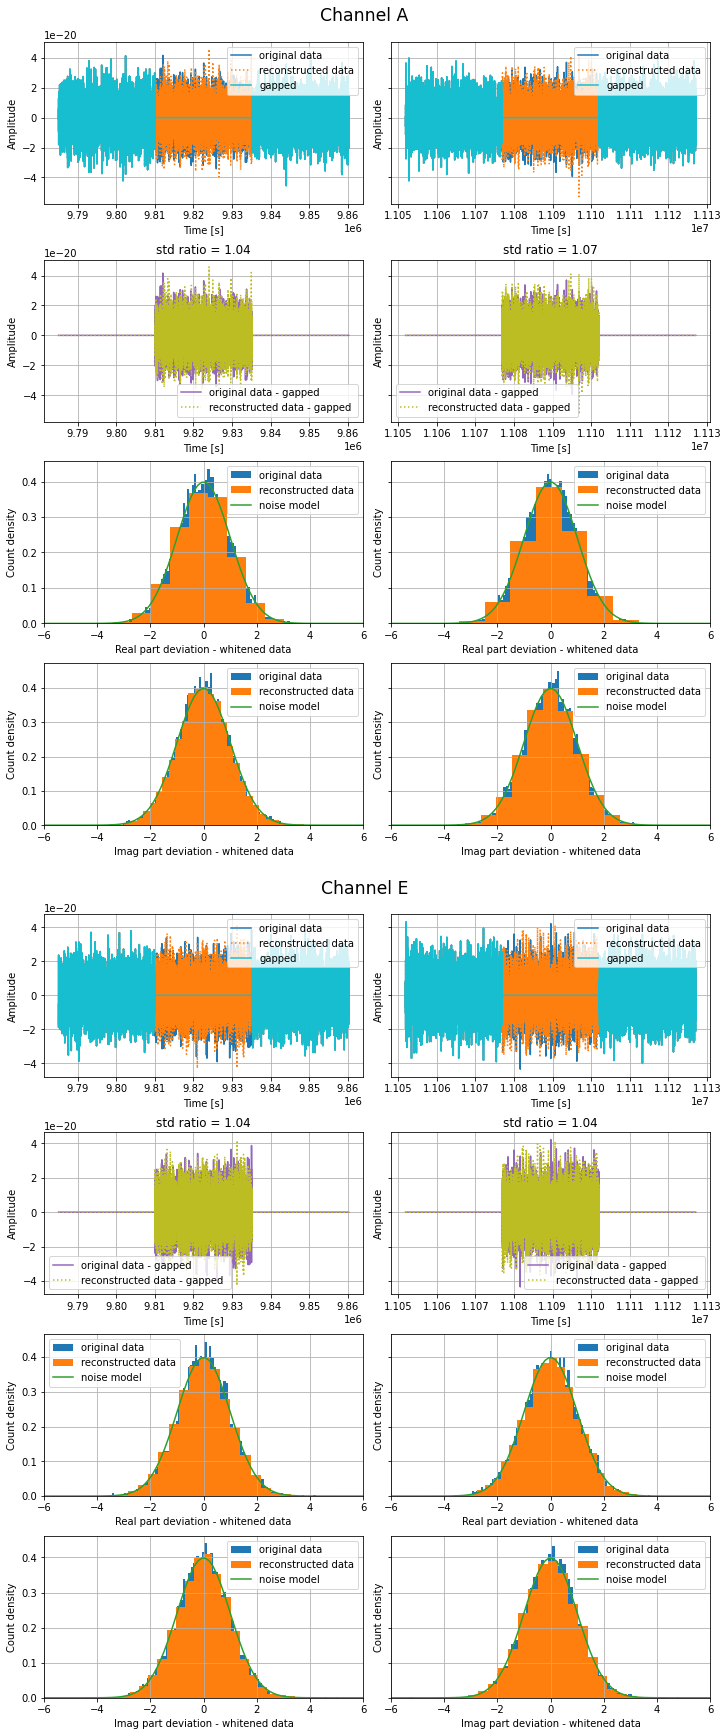

In [43]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

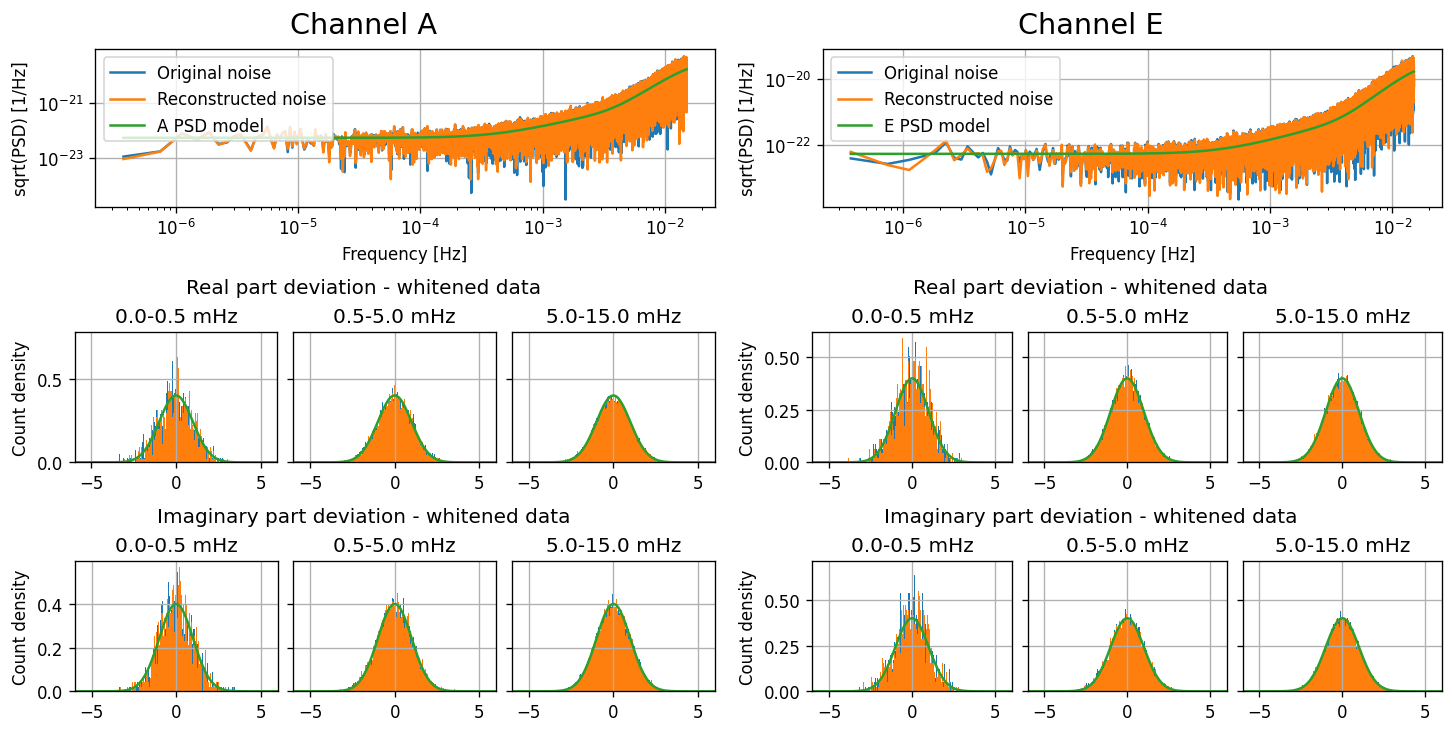

In [44]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 3: `fit_dof=30`, `k_fmin = 1`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 6.87529182434082
Computation of autocovariance + PSD took 0.2537670135498047
Computation of autocovariance + PSD took 0.25013184547424316
Computation of autocovariance + PSD took 0.2599058151245117
Computation of autocovariance + PSD took 0.25511980056762695
Computation of autocovariance + PSD took 0.22764801979064941
Computation of autocovariance + PSD took 0.22931194305419922
Computation of autocovariance + PSD took 0.24382591247558594
Computation of autocovariance + PSD took 0.2491919994354248
Computation of autocovariance + PSD took 0.2504458427429199
Computation of autocovariance + PSD took 0.24351787567138672
Computation of autocovariance + PSD took 7.538074970245361
Computation of autocovariance + PSD took 0.25668787956237793
Computation of autocovariance + PSD took 0.2398388385772705
Computation of autocovariance + PSD took 0.24139809608459473
Computation of autocovariance + PSD took 0.24312591552734375
Computat

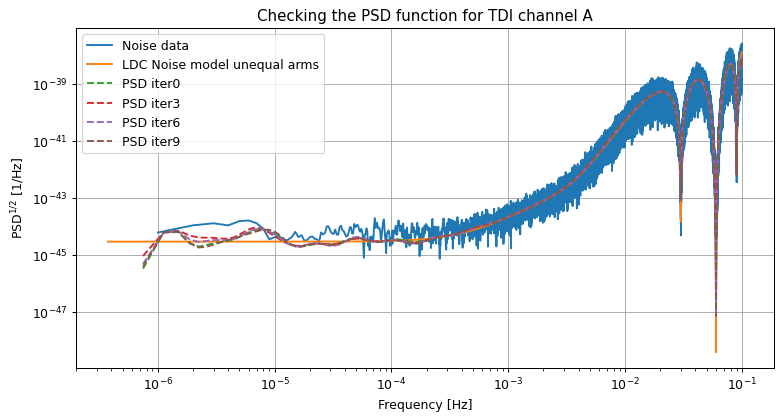

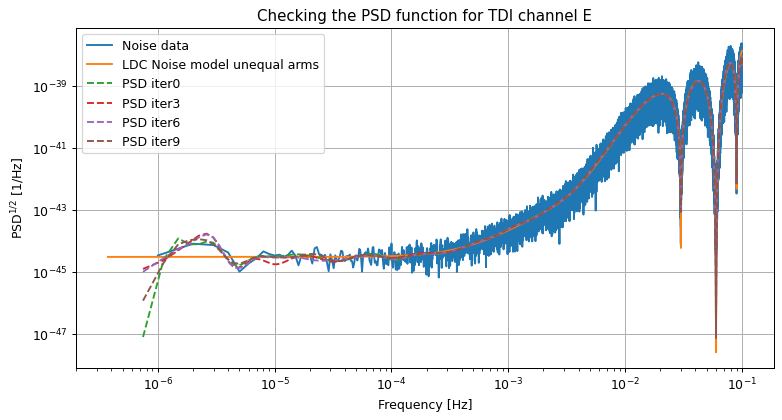

In [45]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 30
k = 1
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))
# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()

ax.legend(loc='best')
ax.grid()

ax.grid()

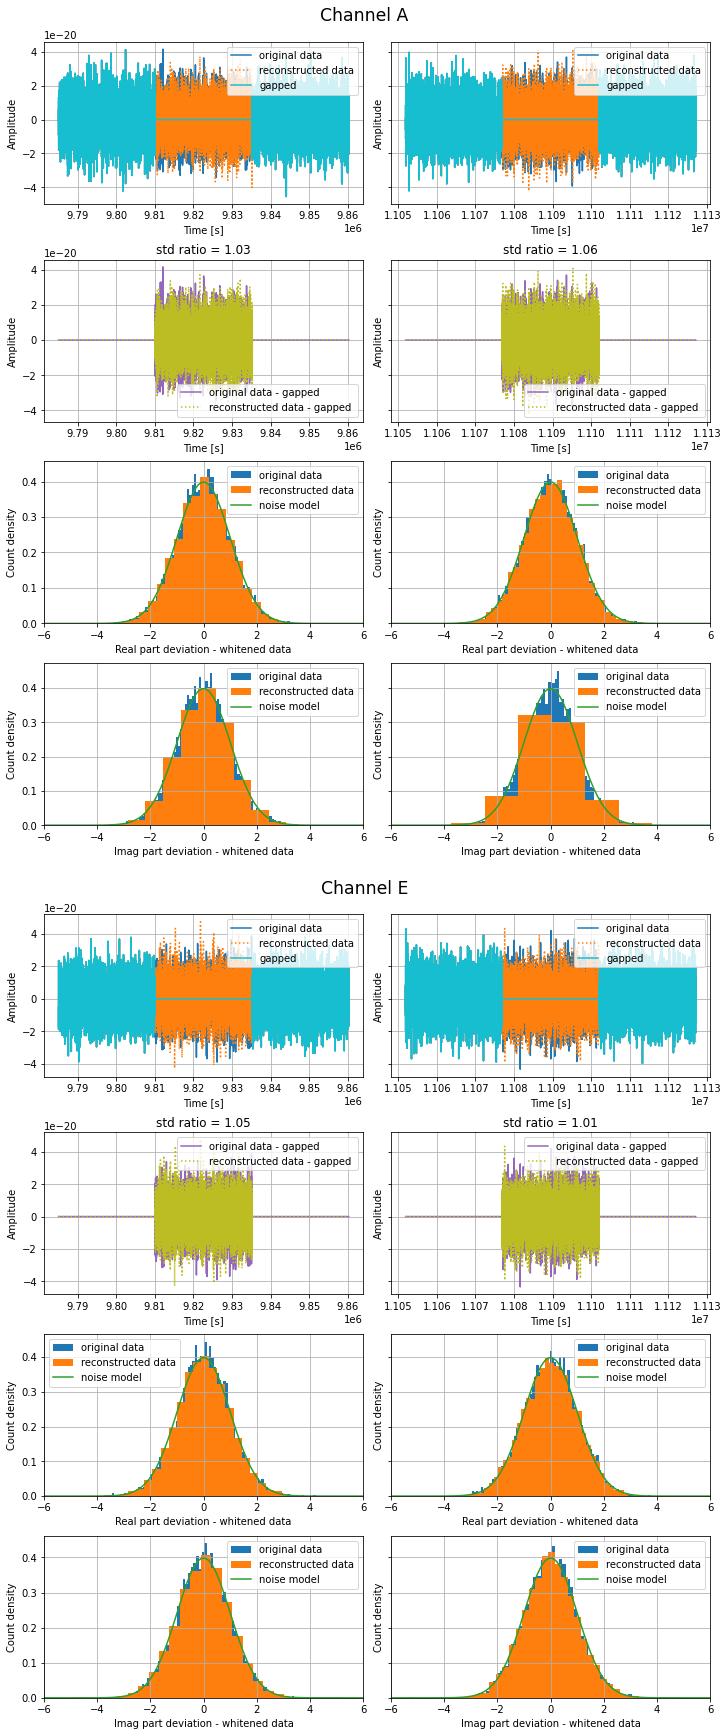

In [46]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

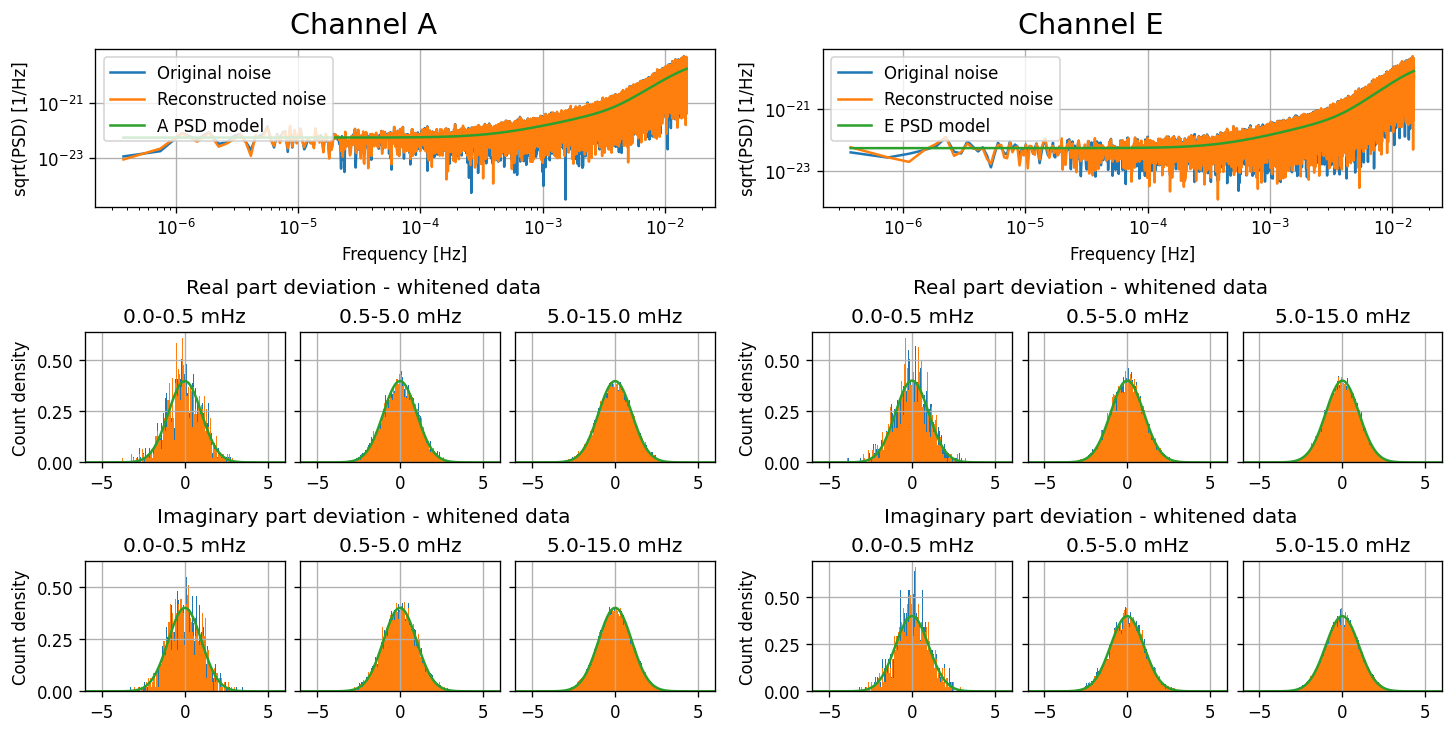

In [47]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 4: `fit_dof=6`, `k_fmin = 5`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 6.593300104141235
Computation of autocovariance + PSD took 0.22523999214172363
Computation of autocovariance + PSD took 0.25030016899108887
Computation of autocovariance + PSD took 0.21822690963745117
Computation of autocovariance + PSD took 0.22066092491149902
Computation of autocovariance + PSD took 0.22022318840026855
Computation of autocovariance + PSD took 0.22314095497131348
Computation of autocovariance + PSD took 0.2188098430633545
Computation of autocovariance + PSD took 0.2353801727294922
Computation of autocovariance + PSD took 0.22516393661499023
Computation of autocovariance + PSD took 0.21972990036010742
Imputation for combination A took 15.353778839111328
Computation of autocovariance + PSD took 6.626667737960815
Computation of autocovariance + PSD took 0.25865697860717773
Computation of autocovariance + PSD took 0.22719693183898926
Computation of autocovariance + PSD took 0.22747278213500977
Computation 

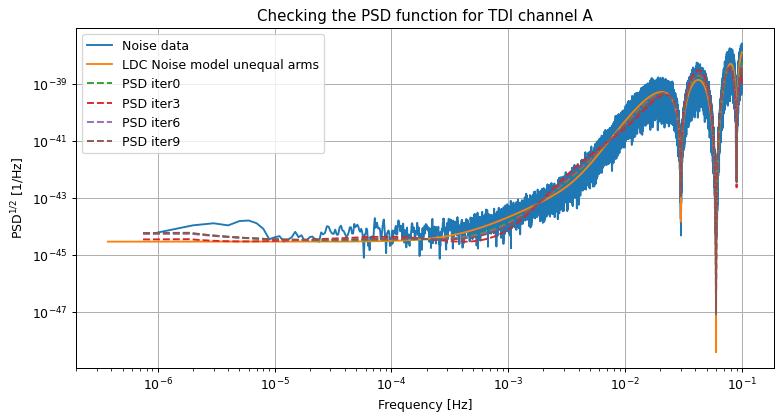

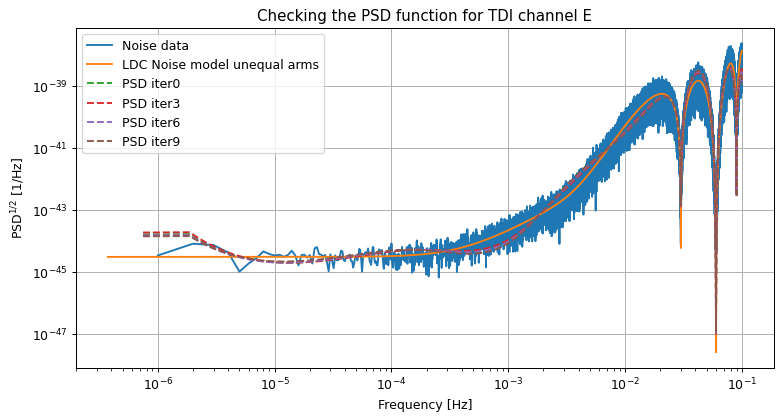

In [48]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 6
k = 5
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))
# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res

        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

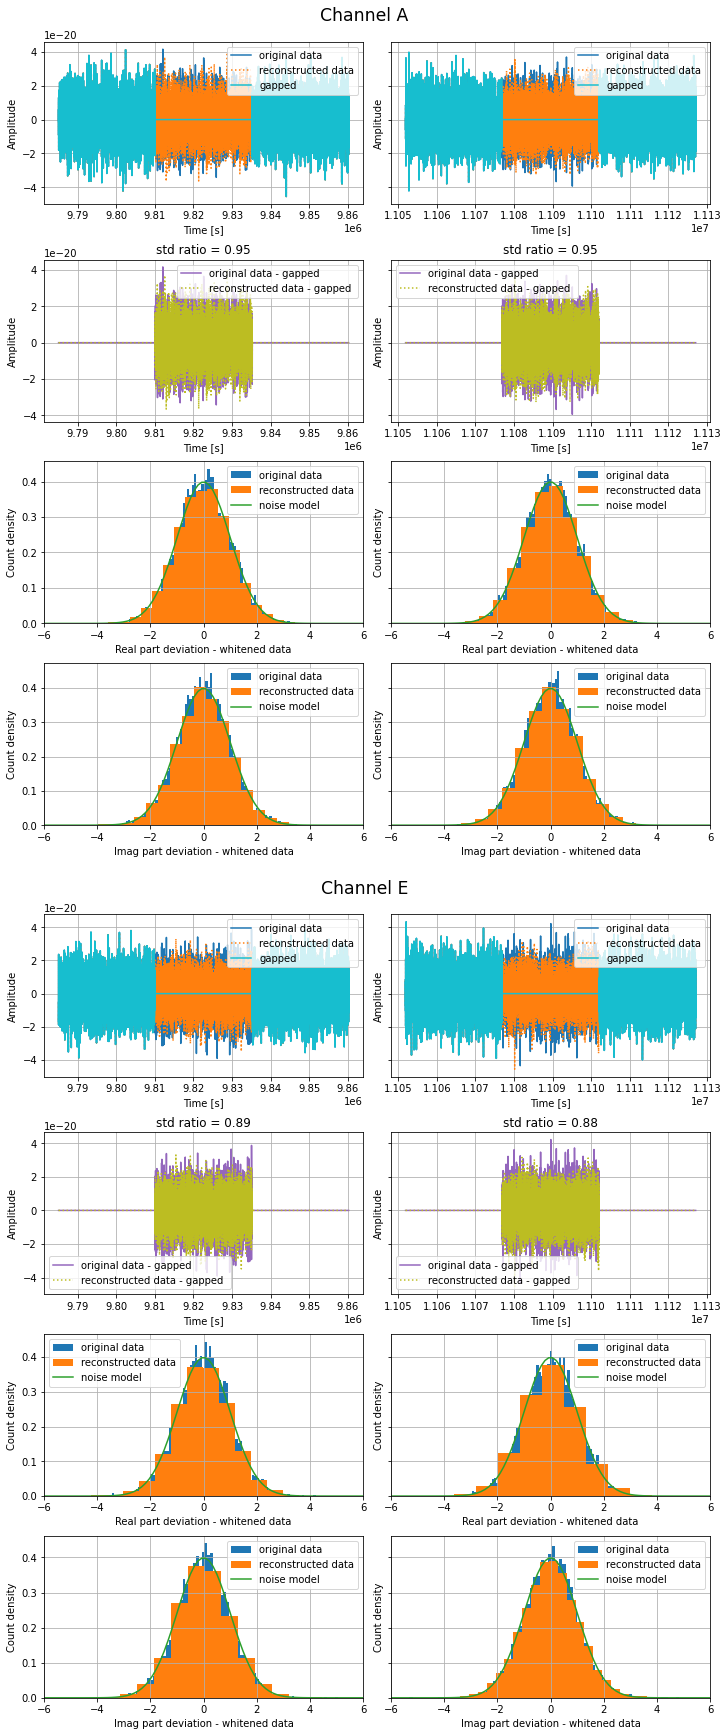

In [49]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

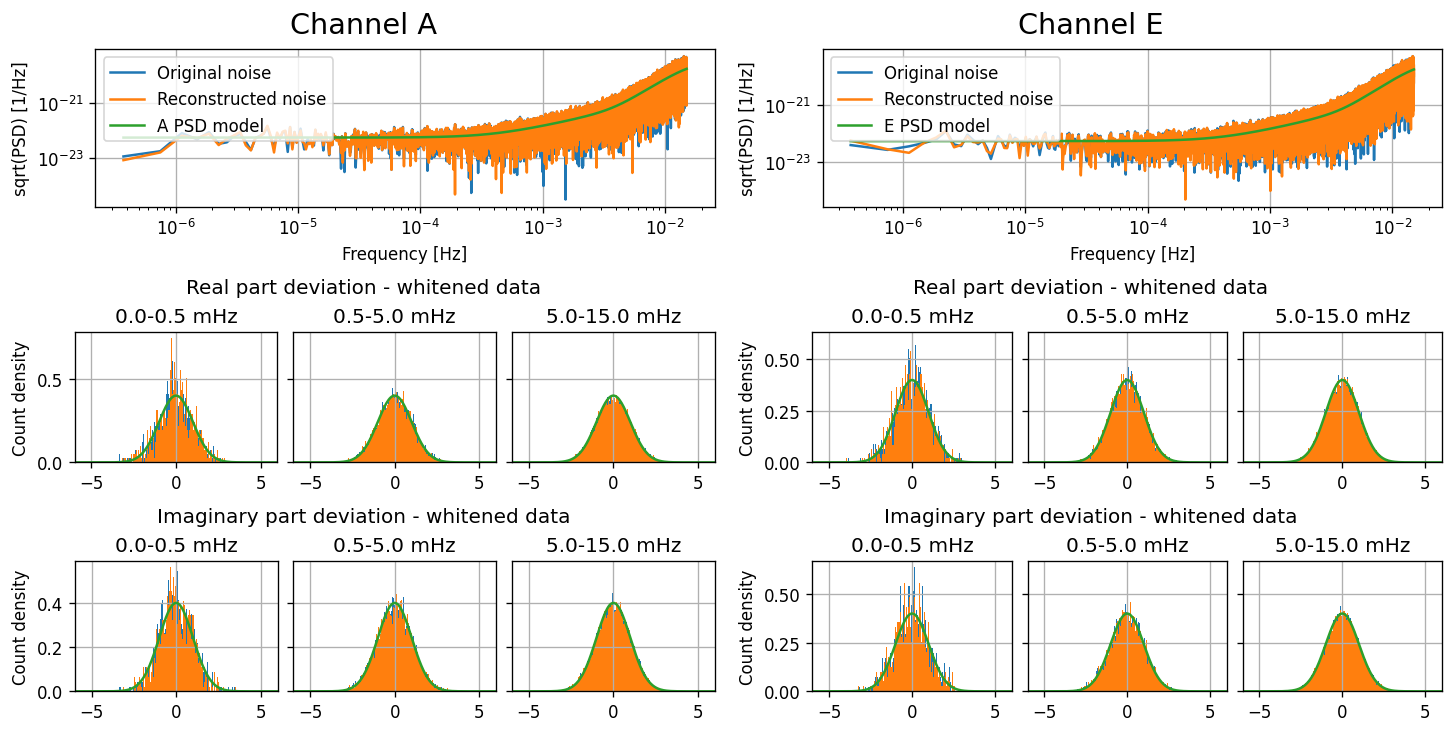

In [50]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 5: `fit_dof=6`, `k_fmin = 10`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 6.9392311573028564
Computation of autocovariance + PSD took 0.2367539405822754
Computation of autocovariance + PSD took 0.21990180015563965
Computation of autocovariance + PSD took 0.22537899017333984
Computation of autocovariance + PSD took 0.22053194046020508
Computation of autocovariance + PSD took 0.22466588020324707
Computation of autocovariance + PSD took 0.22687482833862305
Computation of autocovariance + PSD took 0.21468496322631836
Computation of autocovariance + PSD took 0.21948003768920898
Computation of autocovariance + PSD took 0.21697187423706055
Computation of autocovariance + PSD took 0.23154211044311523
Imputation for combination A took 16.11267113685608
Computation of autocovariance + PSD took 6.241899728775024
Computation of autocovariance + PSD took 0.2158827781677246
Computation of autocovariance + PSD took 0.2625541687011719
Computation of autocovariance + PSD took 0.23567724227905273
Computation o

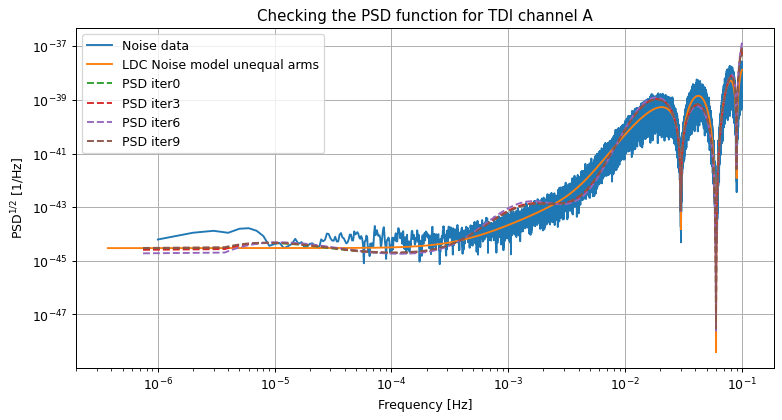

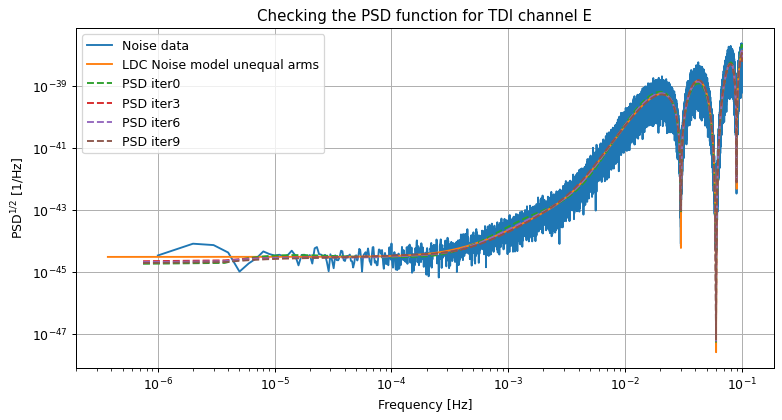

In [51]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 6
k = 10
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))
# perform data imputation

## initialize imputation

for tdi in names:    
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

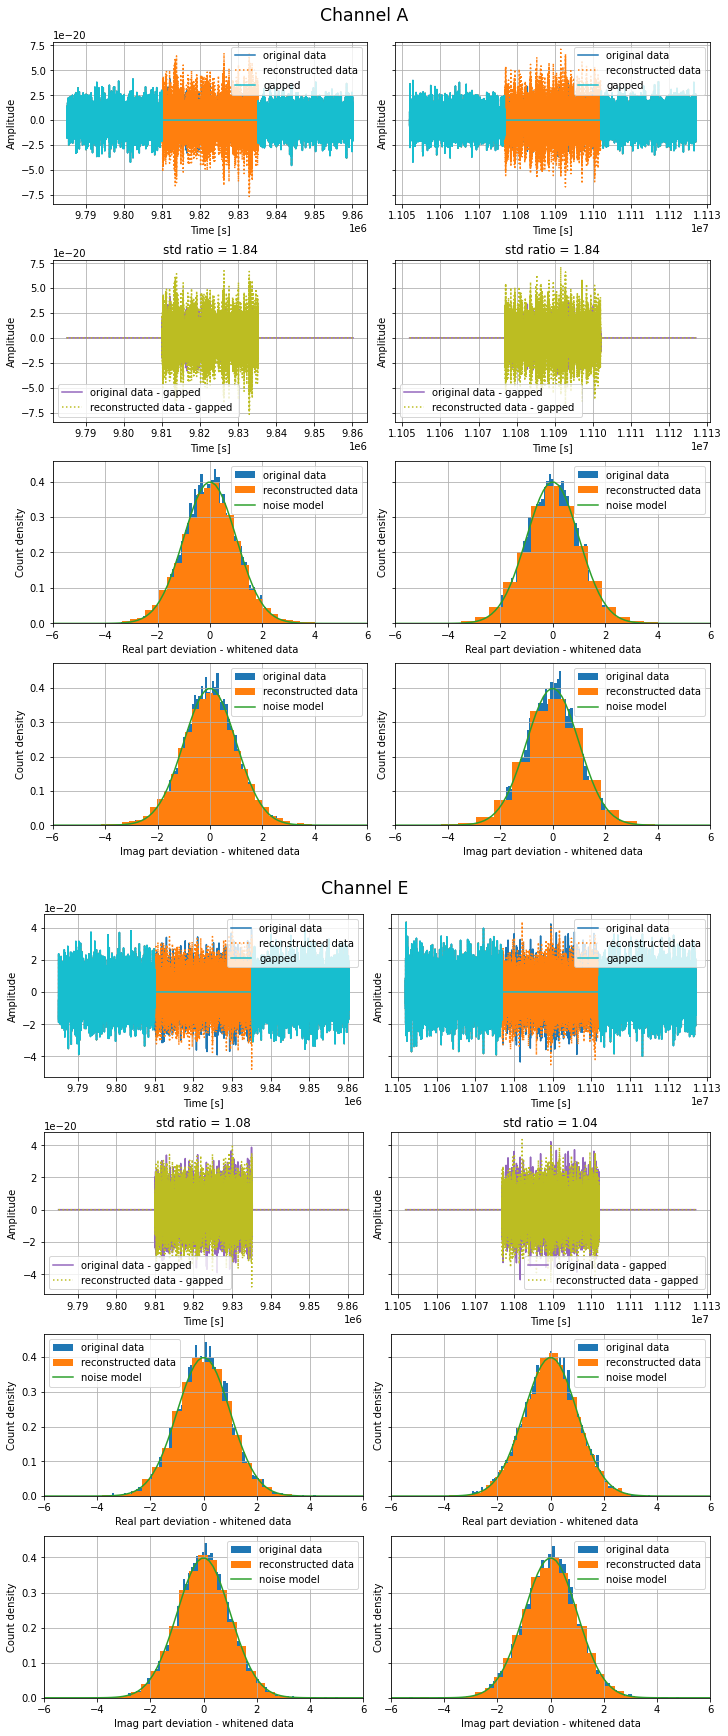

In [52]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

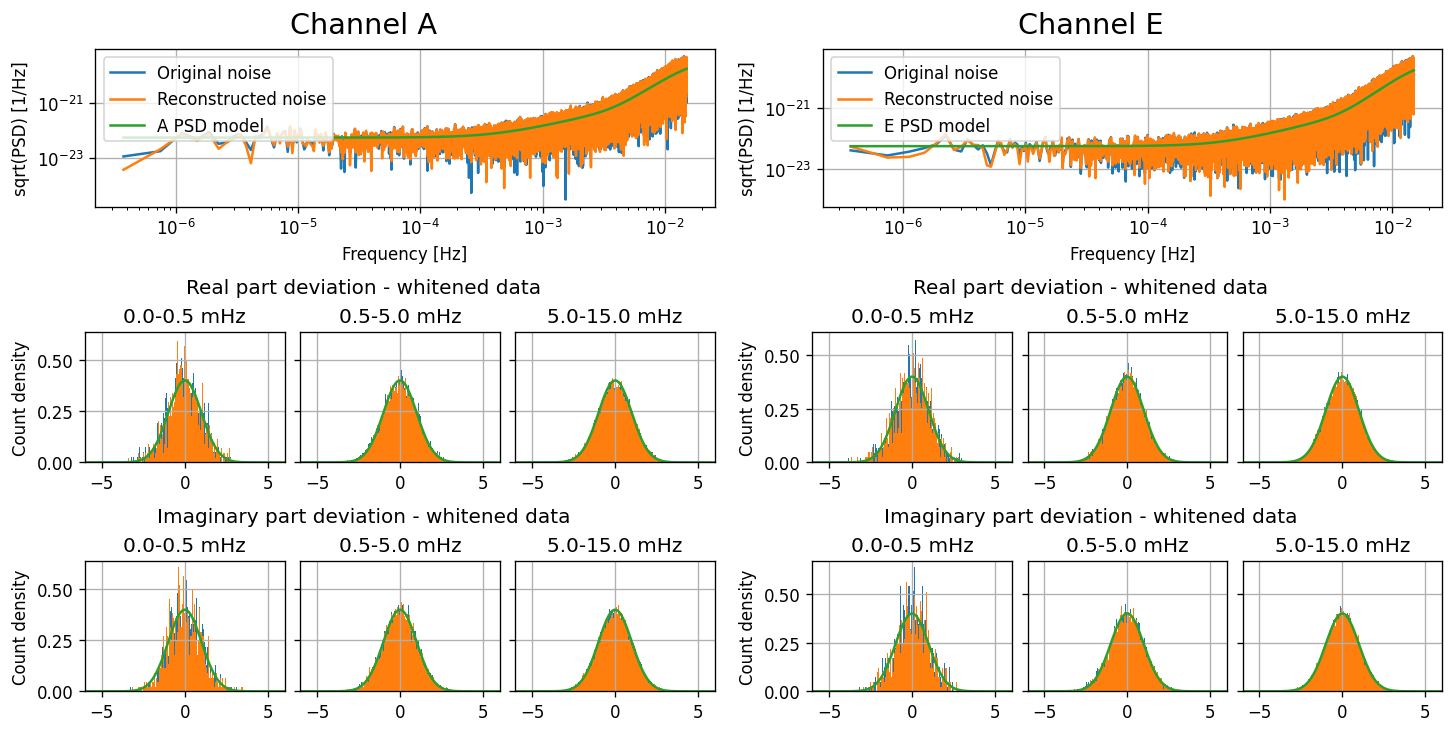

In [53]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 6: `fit_dof=6`, `k_fmin = 20`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 6.992838144302368
Computation of autocovariance + PSD took 0.2444448471069336
Computation of autocovariance + PSD took 0.2638270854949951
Computation of autocovariance + PSD took 0.25679993629455566
Computation of autocovariance + PSD took 0.22875380516052246
Computation of autocovariance + PSD took 0.2513737678527832
Computation of autocovariance + PSD took 0.24713397026062012
Computation of autocovariance + PSD took 0.24593019485473633
Computation of autocovariance + PSD took 0.23295116424560547
Computation of autocovariance + PSD took 0.23016119003295898
Computation of autocovariance + PSD took 0.23134684562683105
Imputation for combination A took 16.366622924804688
Computation of autocovariance + PSD took 6.700568199157715
Computation of autocovariance + PSD took 0.2280890941619873
Computation of autocovariance + PSD took 0.21866607666015625
Computation of autocovariance + PSD took 0.24986910820007324
Computation of

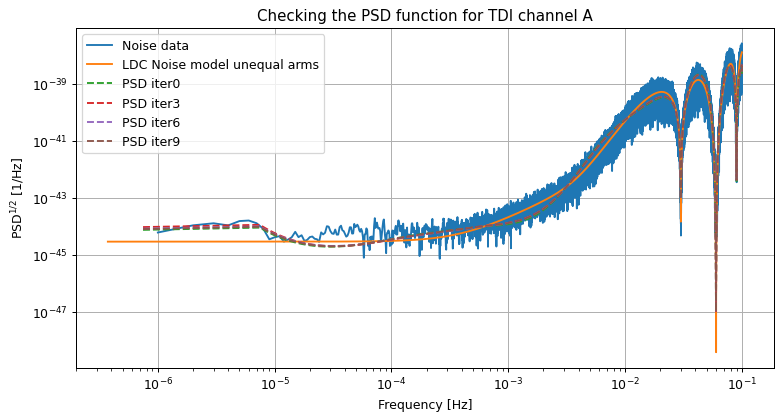

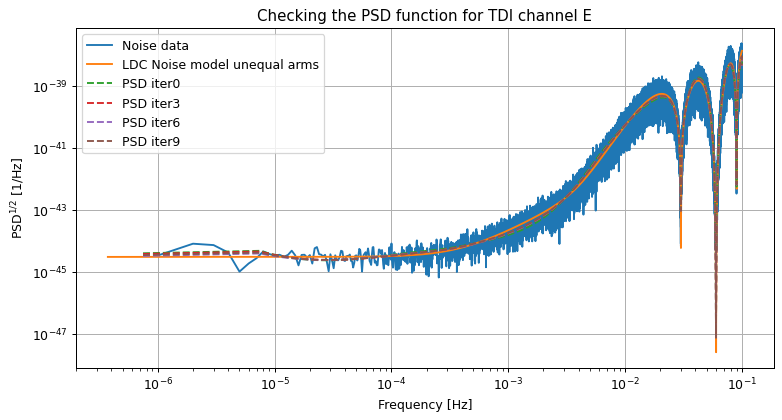

In [54]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 6
k = 20
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))

## initialize imputation

for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()

    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

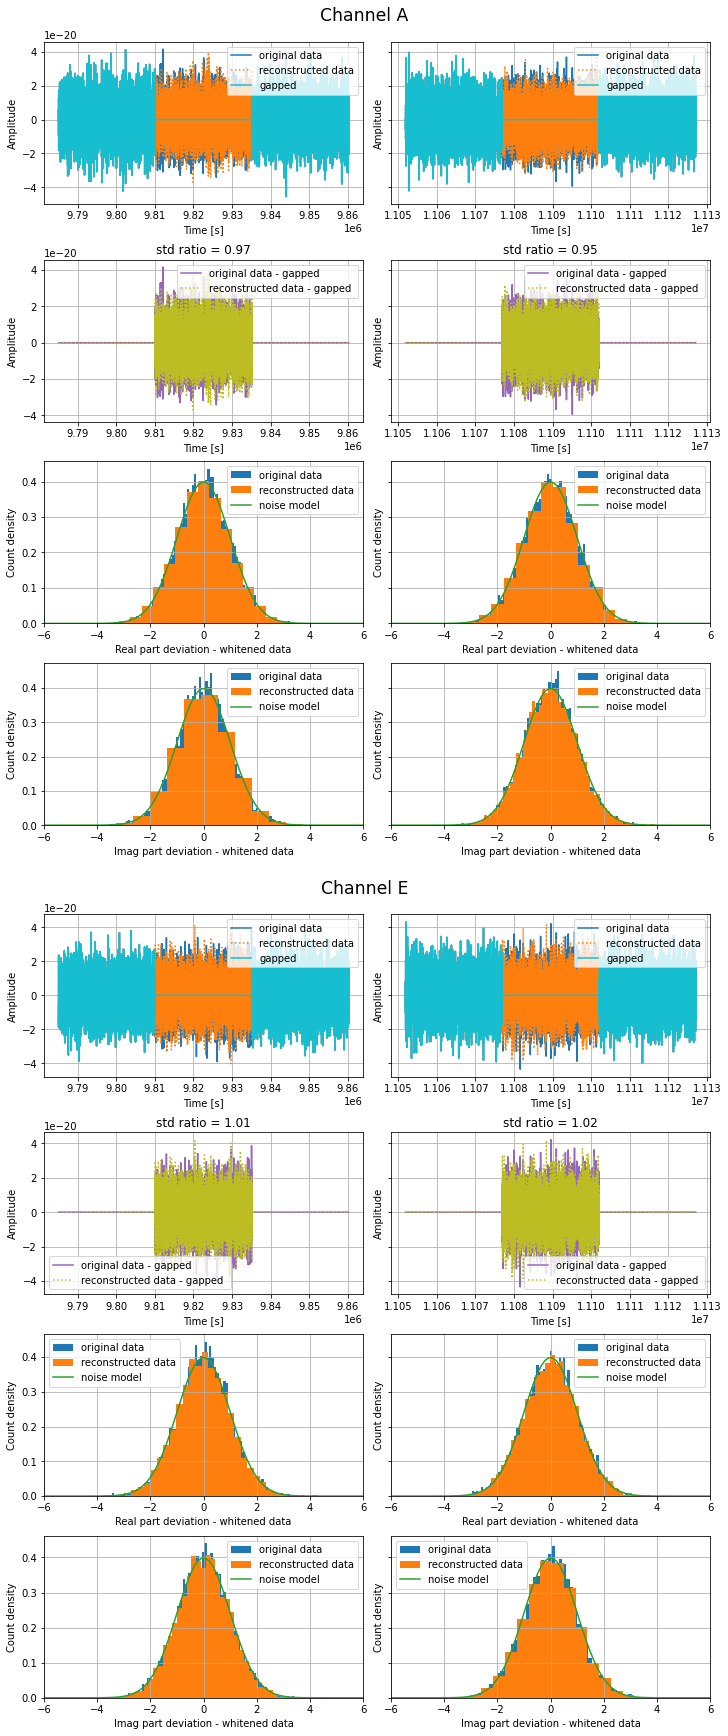

In [55]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

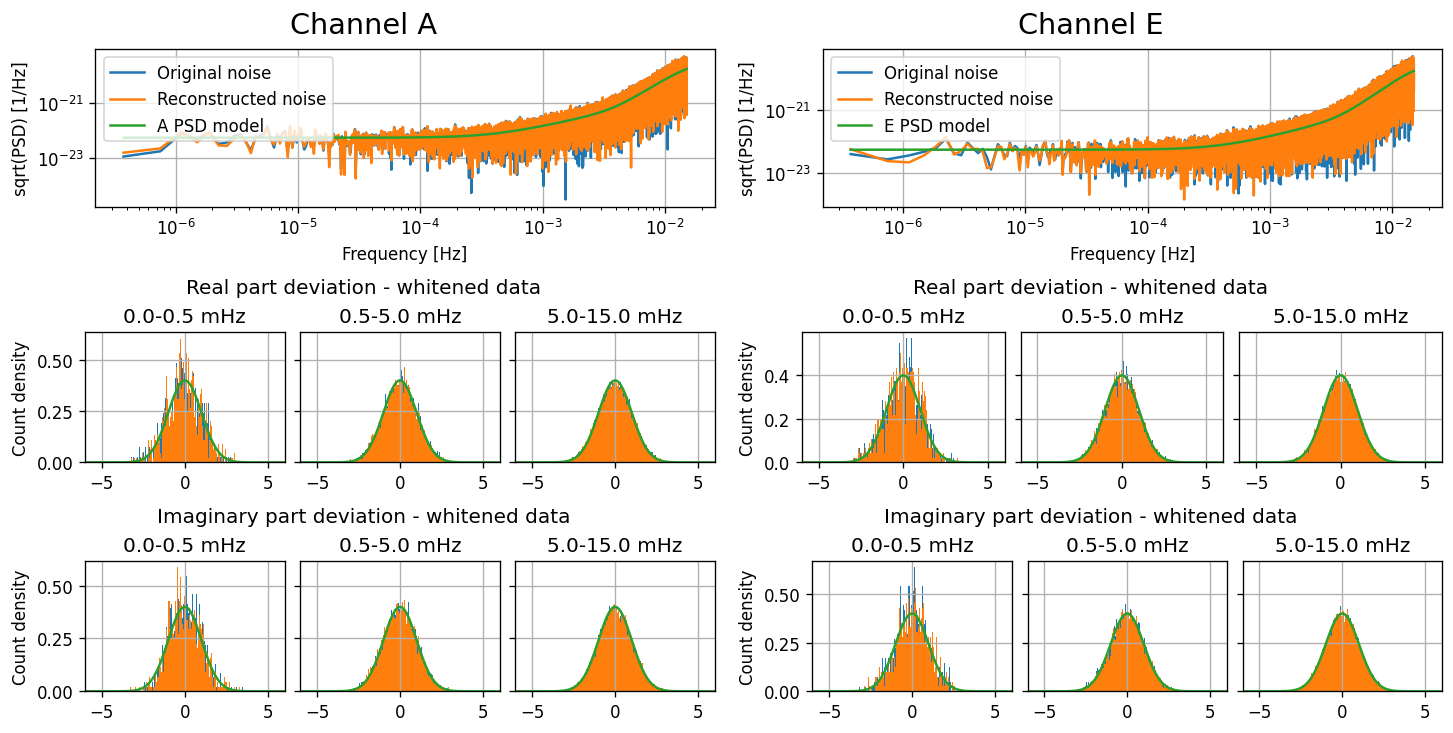

In [56]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 7: `fit_dof=15`, `k_fmin = 5`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 9.899456024169922
Computation of autocovariance + PSD took 0.2570810317993164
Computation of autocovariance + PSD took 0.241286039352417
Computation of autocovariance + PSD took 0.23733210563659668
Computation of autocovariance + PSD took 0.2502002716064453
Computation of autocovariance + PSD took 0.2650258541107178
Computation of autocovariance + PSD took 0.2550027370452881
Computation of autocovariance + PSD took 0.25484275817871094
Computation of autocovariance + PSD took 0.259868860244751
Computation of autocovariance + PSD took 0.23969316482543945
Computation of autocovariance + PSD took 0.24823594093322754
Imputation for combination A took 19.799307107925415
Computation of autocovariance + PSD took 6.7607951164245605
Computation of autocovariance + PSD took 0.21855783462524414
Computation of autocovariance + PSD took 0.22518277168273926
Computation of autocovariance + PSD took 0.21888494491577148
Computation of au

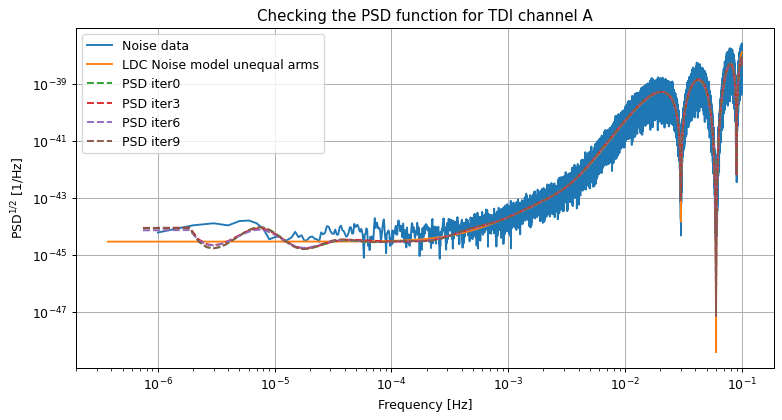

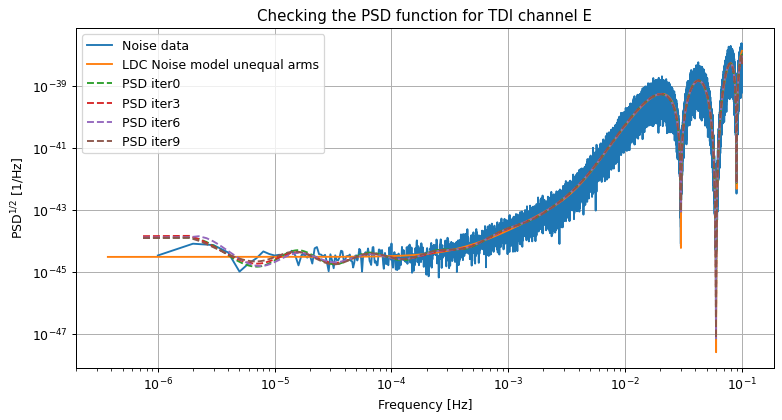

In [57]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 15
k = 5
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))

## initialize imputation

for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
   
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

ax.legend(loc='best')
ax.grid()

ax.grid()

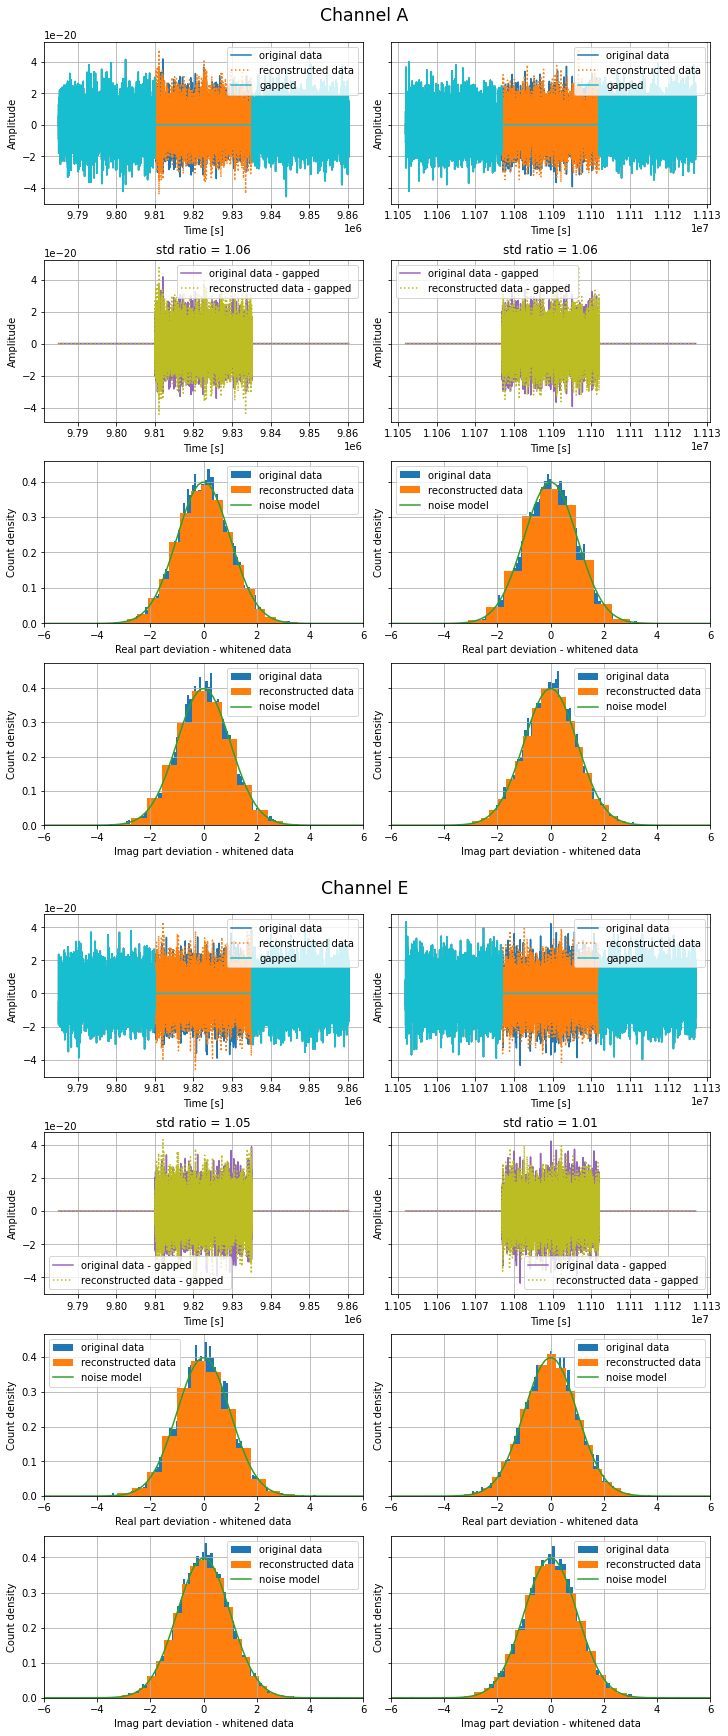

In [58]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

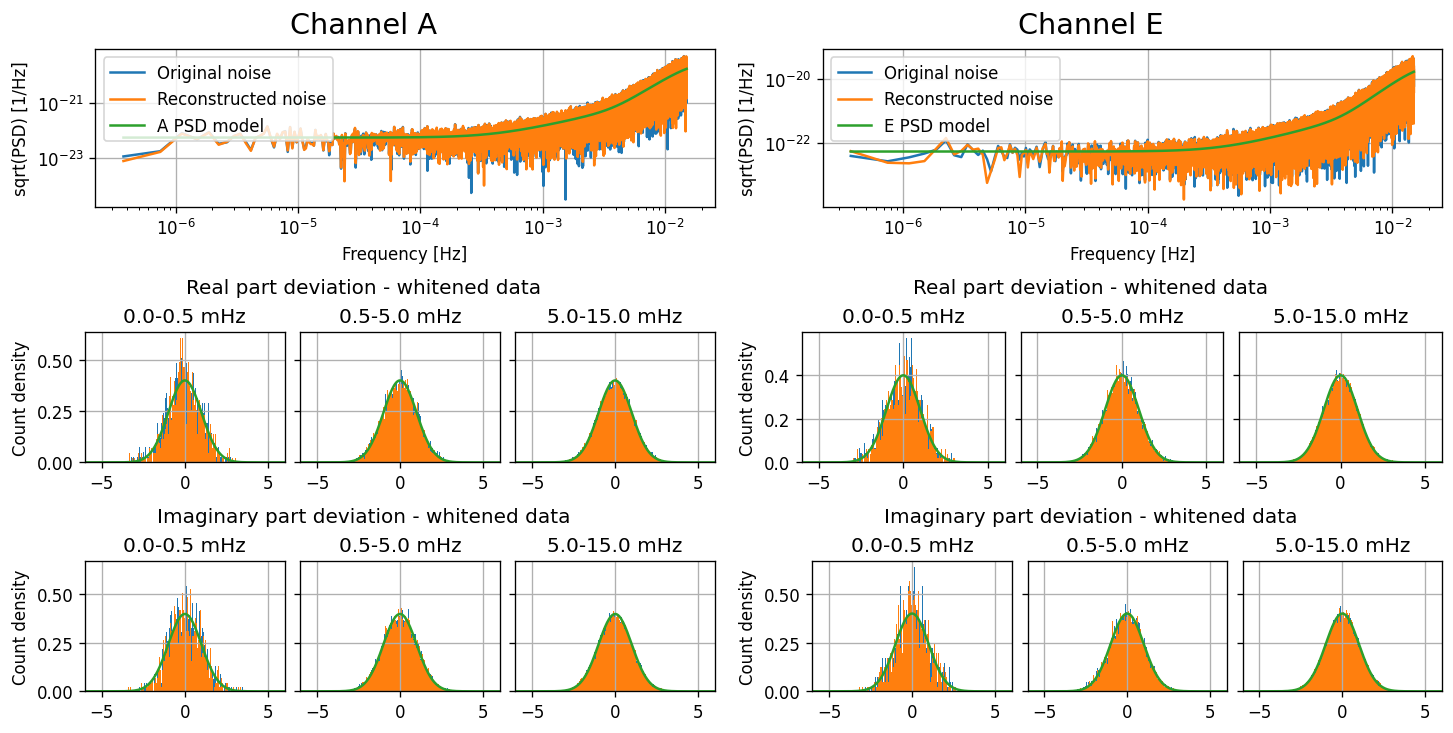

In [59]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 8: `fit_dof=15`, `k_fmin = 10`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 9.014806032180786
Computation of autocovariance + PSD took 0.2539708614349365
Computation of autocovariance + PSD took 0.24702215194702148
Computation of autocovariance + PSD took 0.25275707244873047
Computation of autocovariance + PSD took 0.22588801383972168
Computation of autocovariance + PSD took 0.254749059677124
Computation of autocovariance + PSD took 0.23813772201538086
Computation of autocovariance + PSD took 0.24157476425170898
Computation of autocovariance + PSD took 0.2659142017364502
Computation of autocovariance + PSD took 0.24760222434997559
Computation of autocovariance + PSD took 0.2510356903076172
Imputation for combination A took 18.911144971847534
Computation of autocovariance + PSD took 7.352917194366455
Computation of autocovariance + PSD took 0.2509267330169678
Computation of autocovariance + PSD took 0.2379899024963379
Computation of autocovariance + PSD took 0.24862408638000488
Computation of au

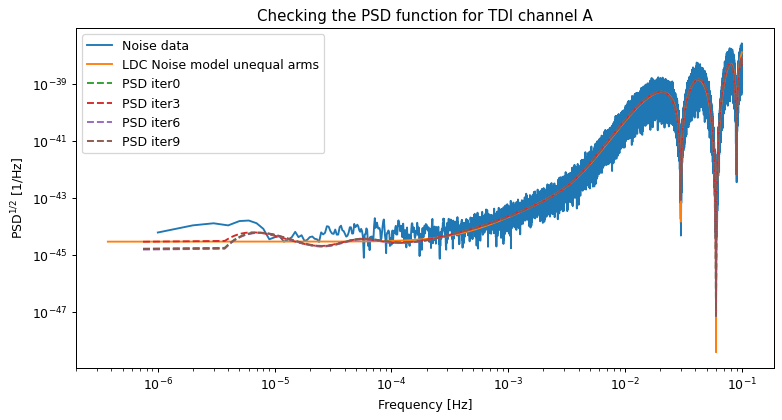

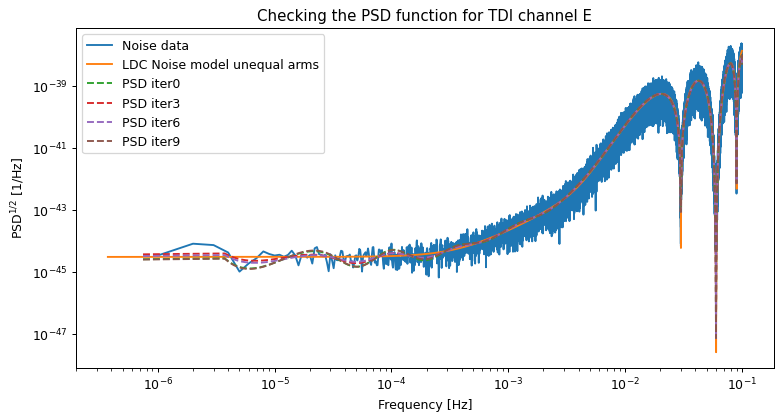

In [60]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 15
k = 10
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))

## initialize imputation
for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    # plot PSD vs PSD-0 model
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # update imputation
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        # plot PSD vs PSD-fit models for every iteration
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

    ax.legend(loc='best')
    ax.grid()

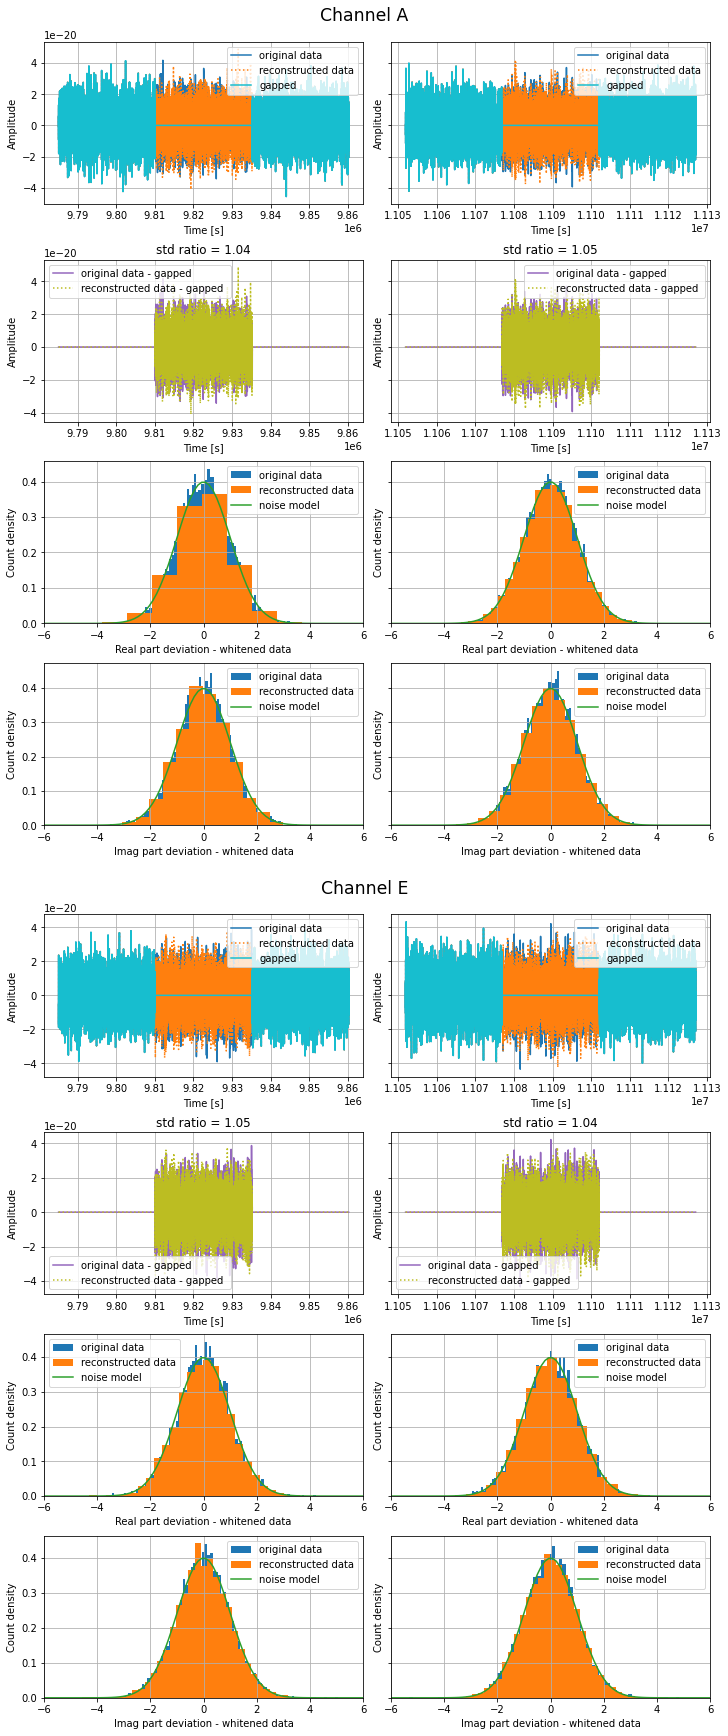

In [61]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

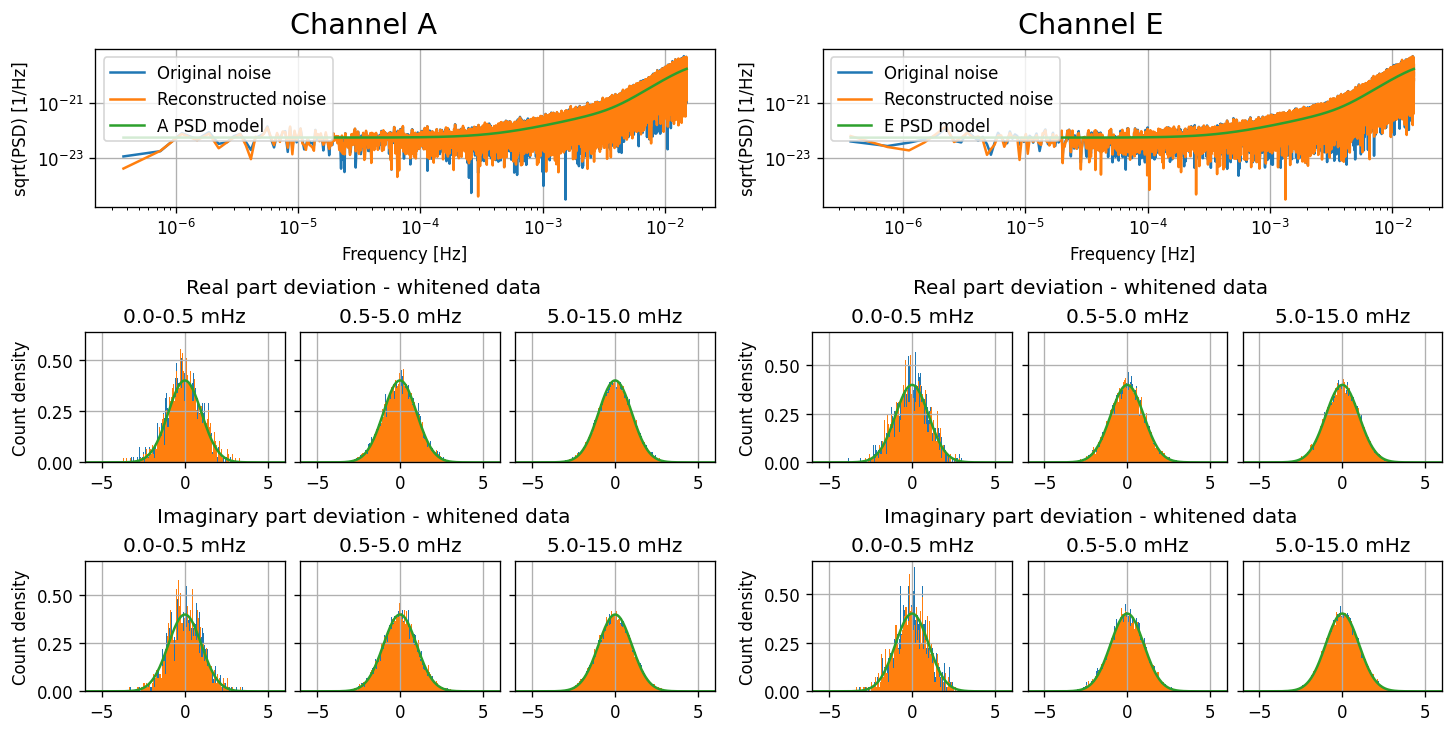

In [62]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

### 5.4 PSD estimated with `fit_type='log_splineratio'`
#### Test 1: `fit_dof=6`, `k_fmin = 1`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 8.753403902053833
Computation of autocovariance + PSD took 0.2622039318084717
Computation of autocovariance + PSD took 0.25486087799072266
Computation of autocovariance + PSD took 0.24157214164733887
Computation of autocovariance + PSD took 0.2438960075378418
Computation of autocovariance + PSD took 0.2545499801635742
Computation of autocovariance + PSD took 0.24315810203552246
Computation of autocovariance + PSD took 0.22908616065979004
Computation of autocovariance + PSD took 0.2417459487915039
Computation of autocovariance + PSD took 0.23306012153625488
Computation of autocovariance + PSD took 0.2259519100189209
Imputation for combination A took 19.285860061645508
Computation of autocovariance + PSD took 6.54175877571106
Computation of autocovariance + PSD took 0.23661279678344727
Computation of autocovariance + PSD took 0.2441730499267578
Computation of autocovariance + PSD took 0.21521401405334473
Computation of au

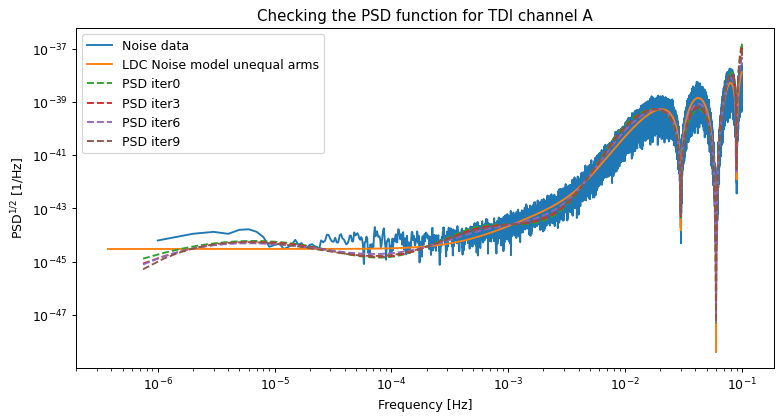

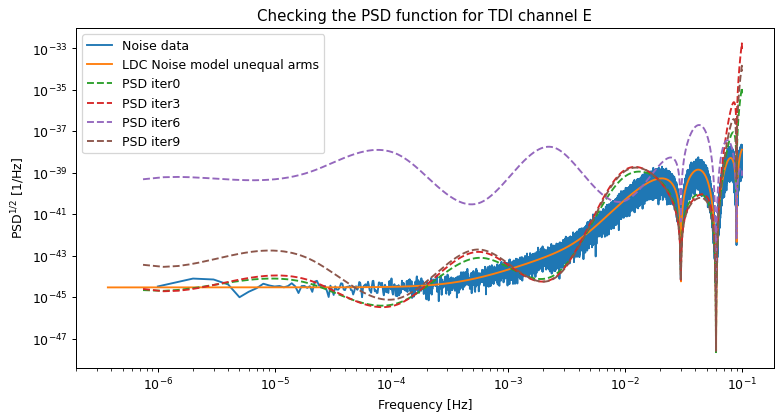

In [63]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'logratio_spline'
fit_dof = 6
k = 1
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))

## initialize imputation
for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    # plot PSD vs PSD-0 model
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # update imputation
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        # plot PSD vs PSD-fit models for every iteration
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

    ax.legend(loc='best')
    ax.grid()

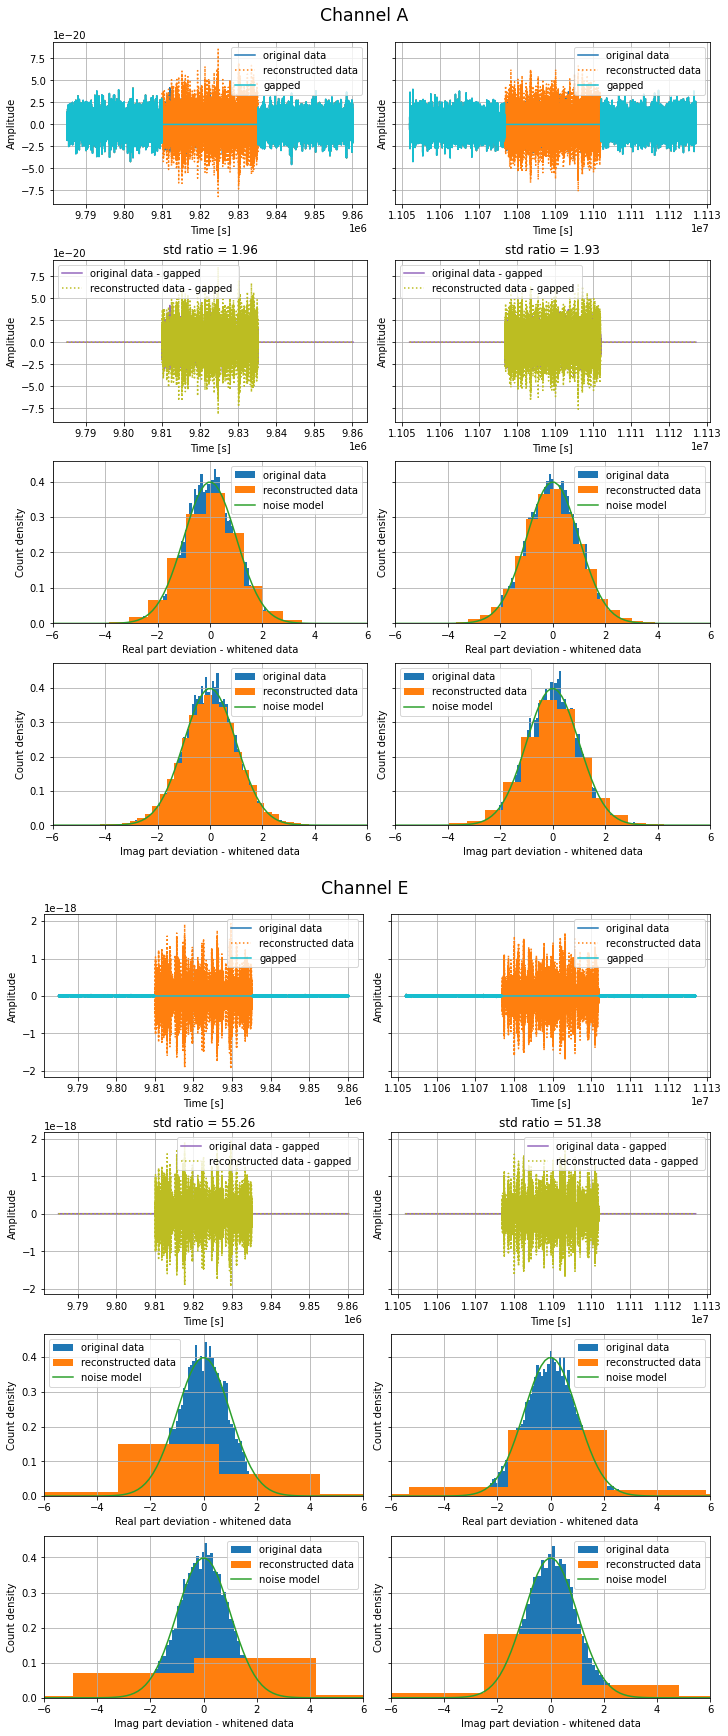

In [64]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

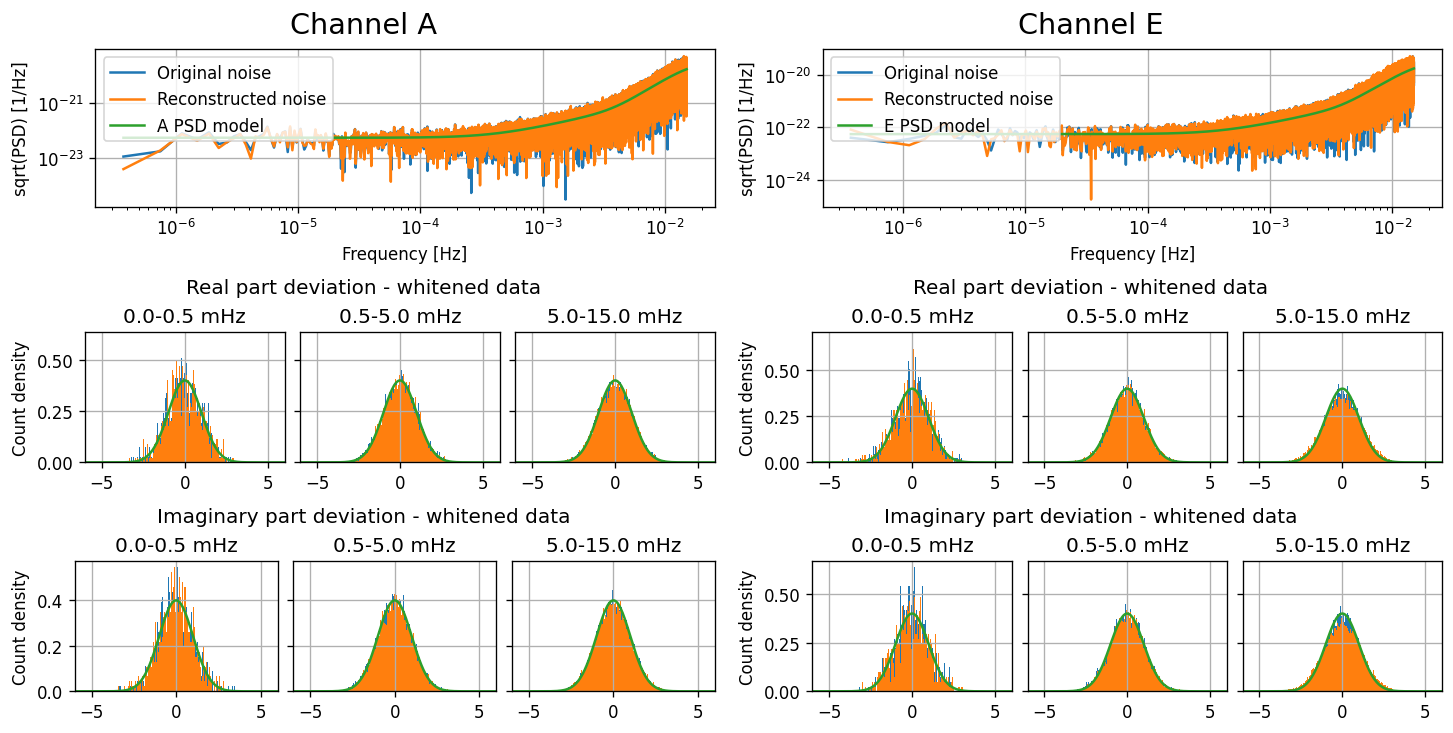

In [65]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 2: `fit_dof=15`, `k_fmin = 5`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 7.9519360065460205
Computation of autocovariance + PSD took 0.2526378631591797
Computation of autocovariance + PSD took 0.24643731117248535
Computation of autocovariance + PSD took 0.2414851188659668
Computation of autocovariance + PSD took 0.24423694610595703
Computation of autocovariance + PSD took 0.25115108489990234
Computation of autocovariance + PSD took 0.24080109596252441
Computation of autocovariance + PSD took 0.23965096473693848
Computation of autocovariance + PSD took 0.24434709548950195
Computation of autocovariance + PSD took 0.26278090476989746
Computation of autocovariance + PSD took 0.23808908462524414
Imputation for combination A took 18.035069227218628
Computation of autocovariance + PSD took 10.807759046554565
Computation of autocovariance + PSD took 0.25130295753479004
Computation of autocovariance + PSD took 0.26717281341552734
Computation of autocovariance + PSD took 0.266948938369751
Computation 

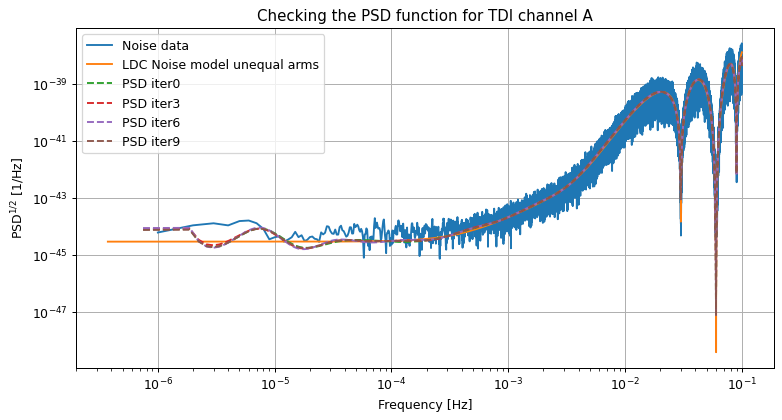

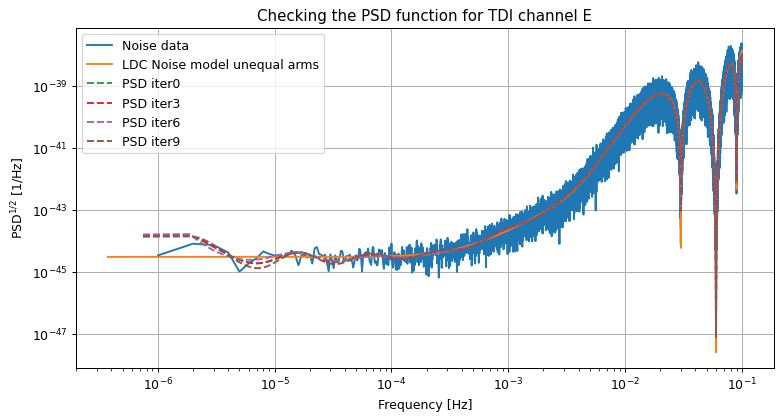

In [66]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'logratio_spline'
fit_dof = 15
k = 5
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))

## initialize imputation
for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    # plot PSD vs PSD-0 model
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # update imputation
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        # plot PSD vs PSD-fit models for every iteration
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

    ax.legend(loc='best')
ax.grid()
ax.grid()

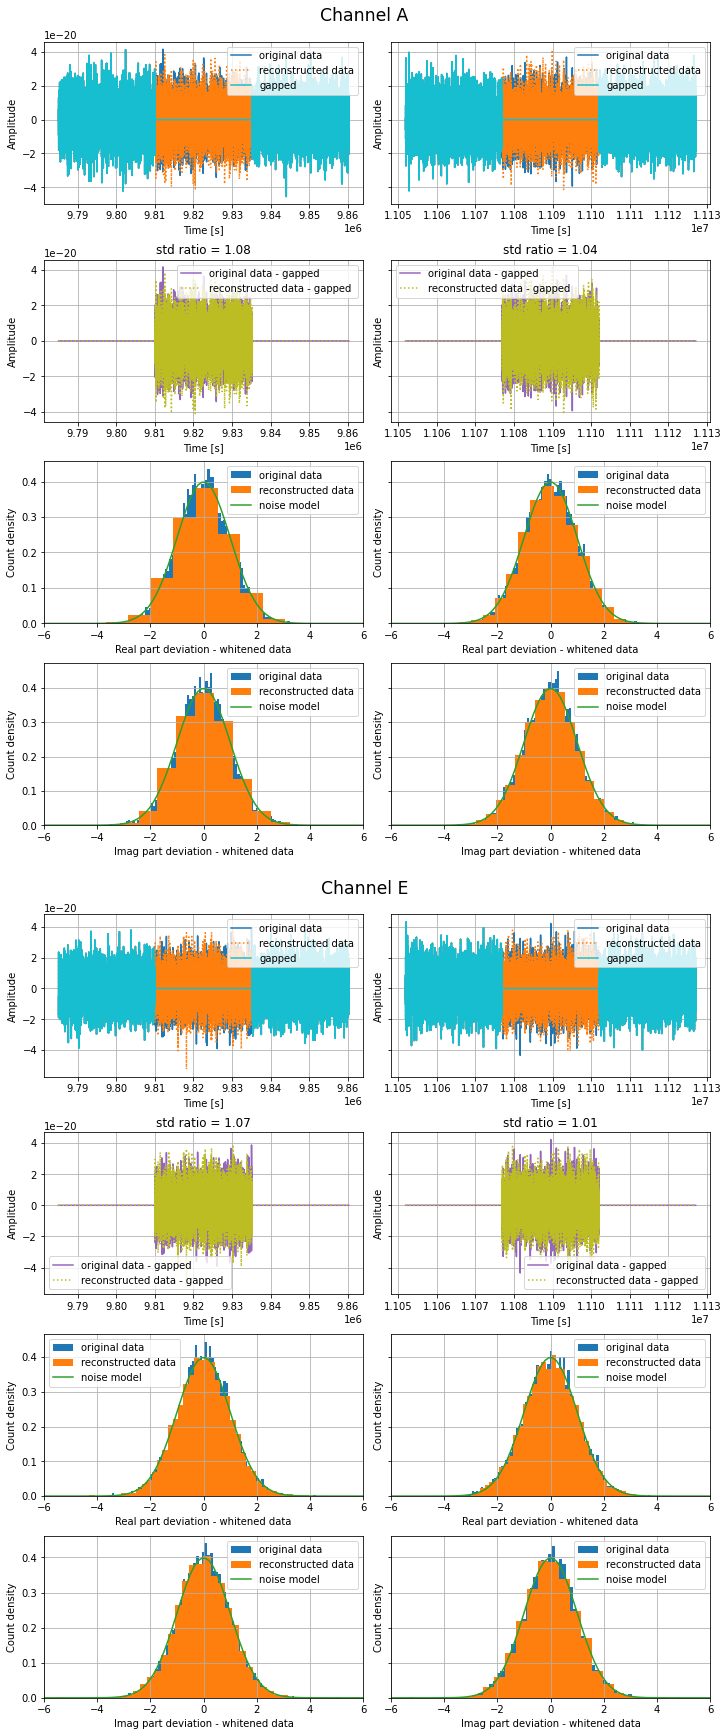

In [67]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

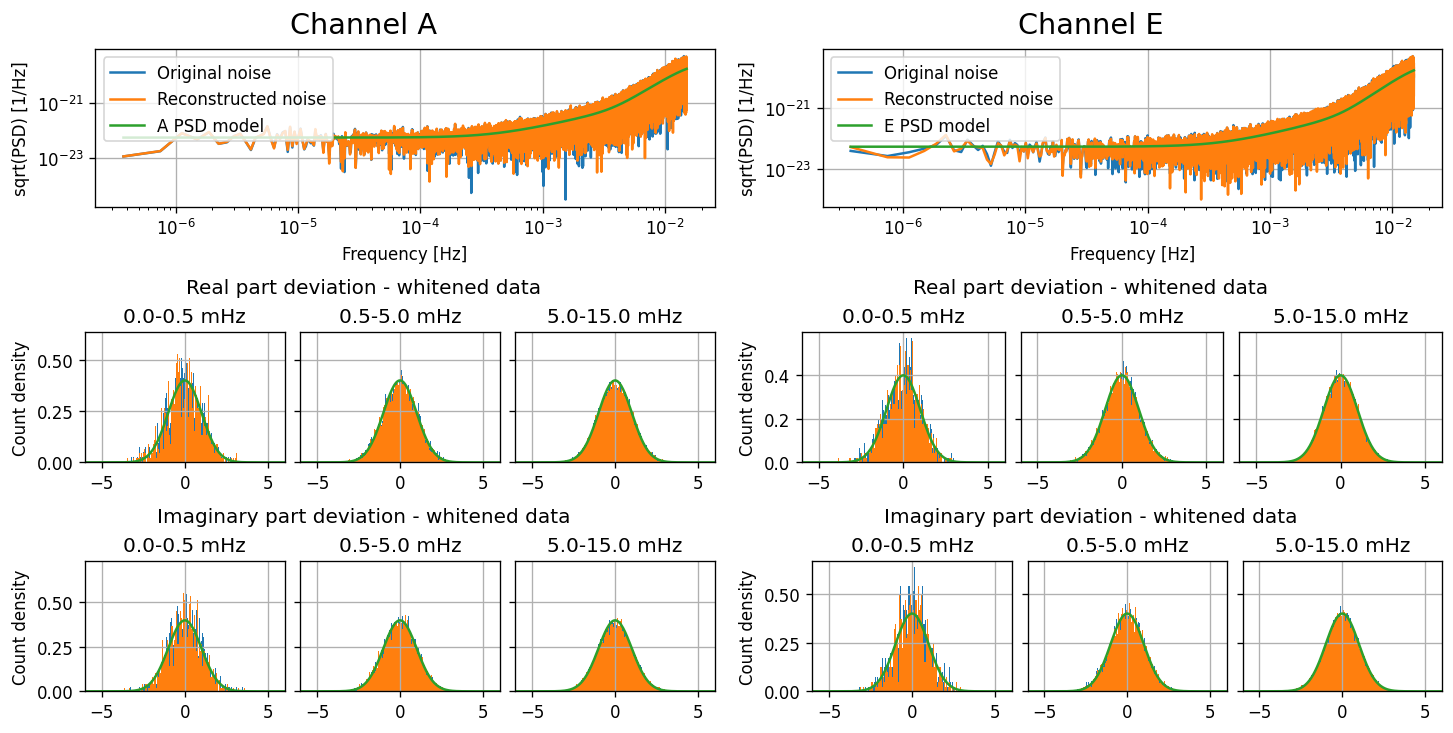

In [68]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 3: `fit_dof=30`, `k_fmin = 5`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 7.495975971221924
Computation of autocovariance + PSD took 0.24004697799682617
Computation of autocovariance + PSD took 0.2287747859954834
Computation of autocovariance + PSD took 0.23923611640930176
Computation of autocovariance + PSD took 0.23952007293701172
Computation of autocovariance + PSD took 0.24938321113586426
Computation of autocovariance + PSD took 0.23488926887512207
Computation of autocovariance + PSD took 0.23984718322753906
Computation of autocovariance + PSD took 0.23617291450500488
Computation of autocovariance + PSD took 0.2509489059448242
Computation of autocovariance + PSD took 0.2544219493865967
Imputation for combination A took 18.006314039230347
Computation of autocovariance + PSD took 7.194545745849609
Computation of autocovariance + PSD took 0.28815579414367676
Computation of autocovariance + PSD took 0.2602412700653076
Computation of autocovariance + PSD took 0.27120089530944824
Computation of

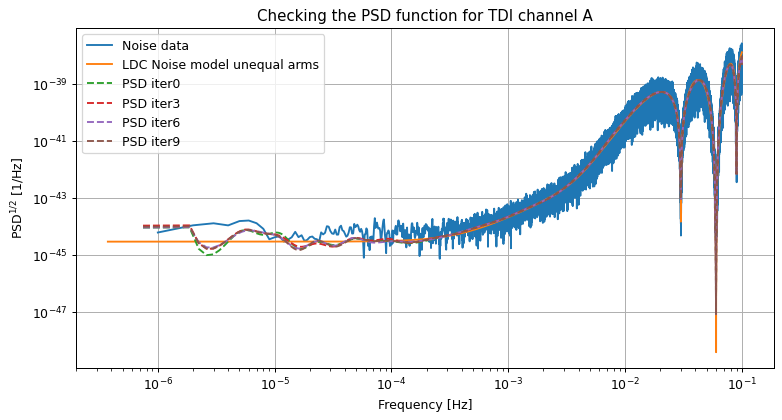

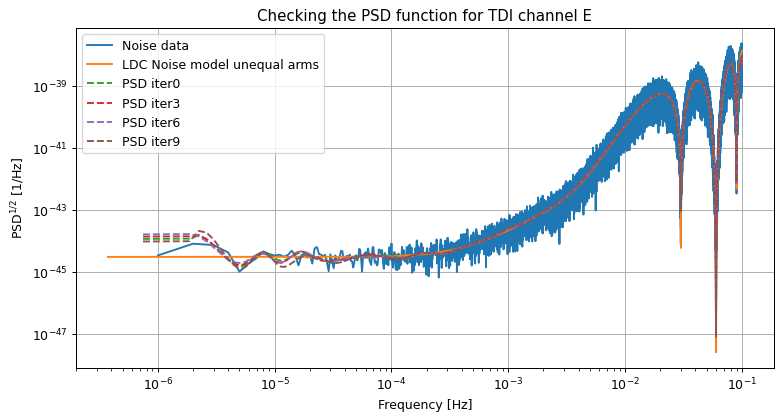

In [69]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'logratio_spline'
fit_dof = 30
k = 5
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))

## initialize imputation
for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    # plot PSD vs PSD-0 model
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # update imputation
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        # plot PSD vs PSD-fit models for every iteration
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

    ax.legend(loc='best')
ax.grid()
ax.grid()

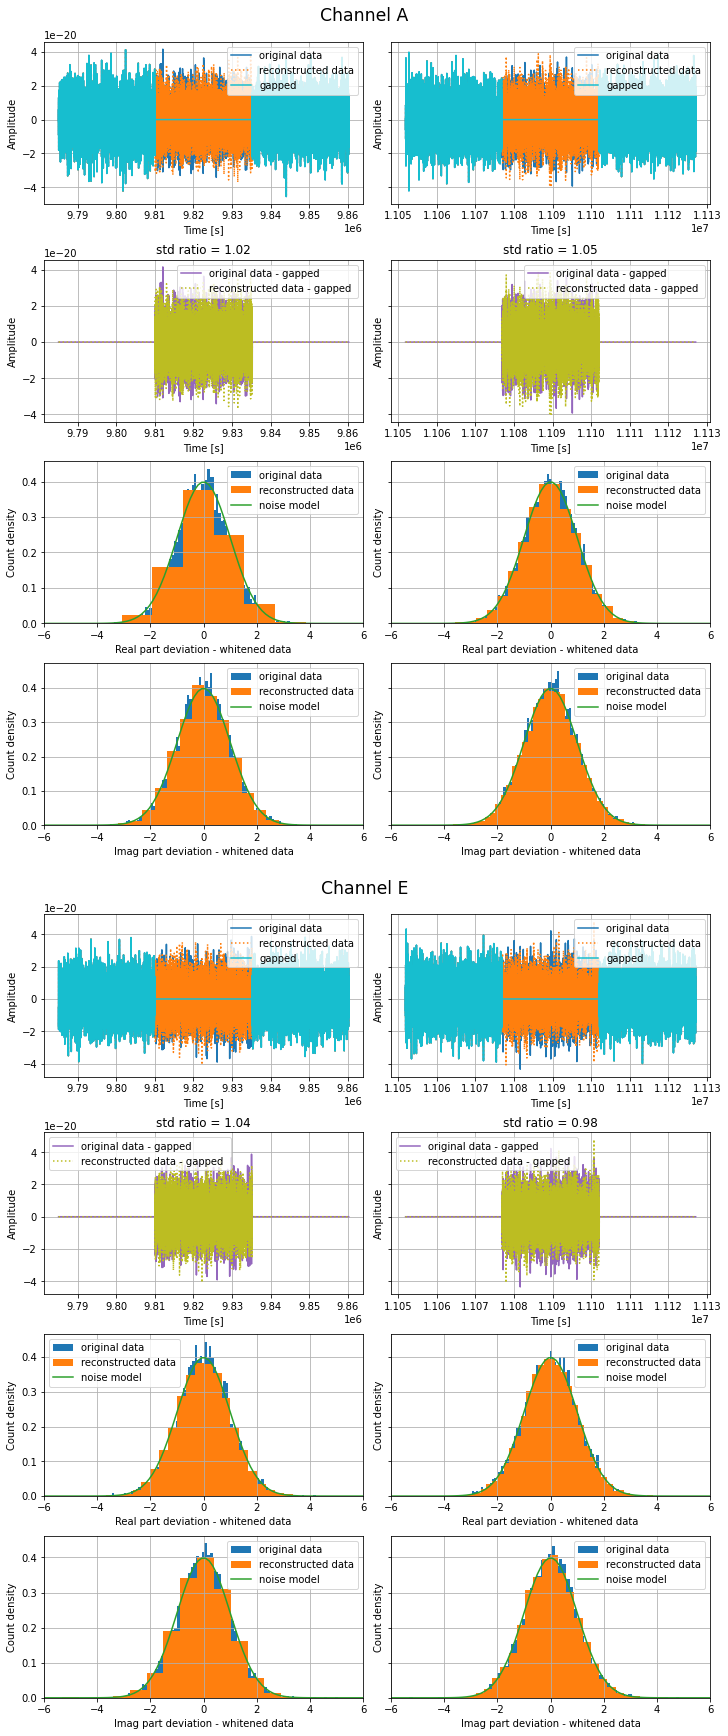

In [70]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

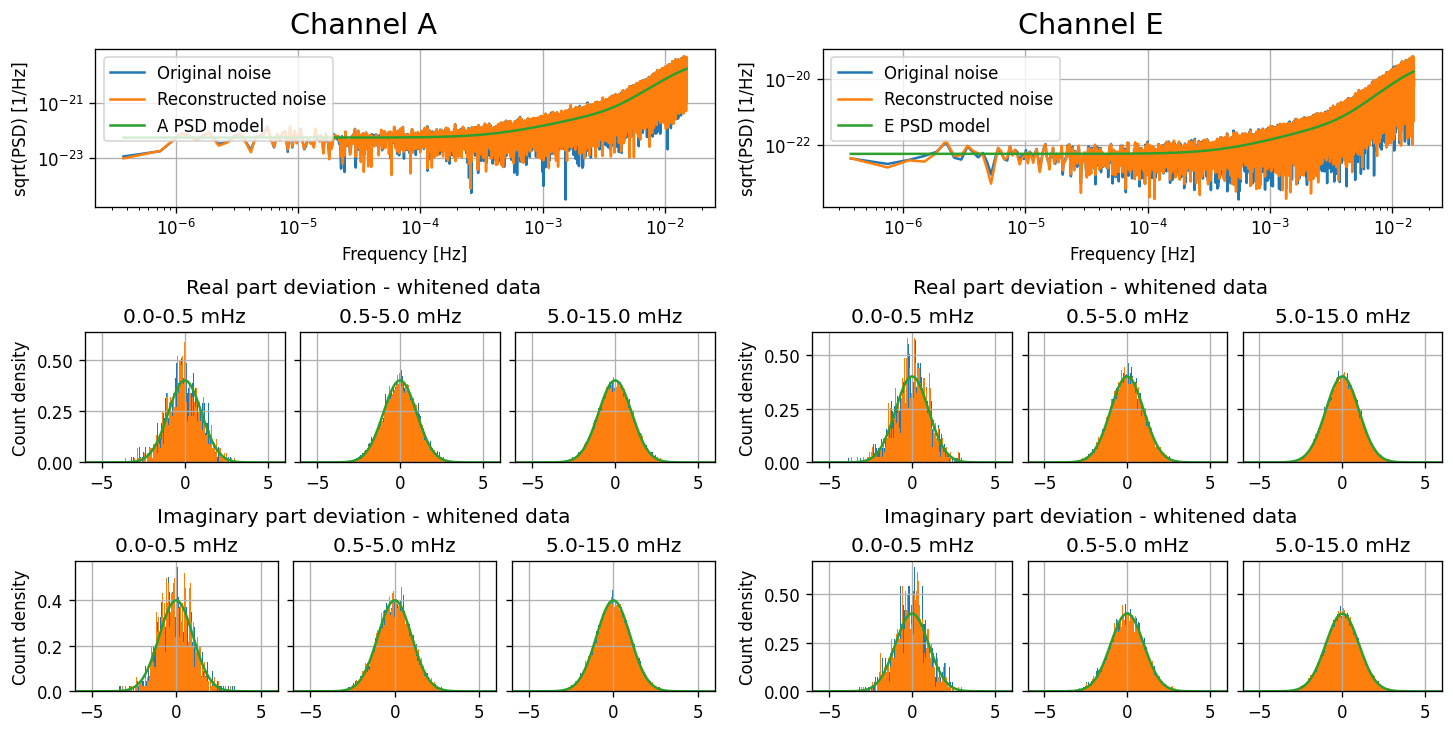

In [71]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 3: `fit_dof=15`, `k_fmin = 10`, `n_iter=10`

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 8.497614860534668
Computation of autocovariance + PSD took 0.24368071556091309
Computation of autocovariance + PSD took 0.23626208305358887
Computation of autocovariance + PSD took 0.26371288299560547
Computation of autocovariance + PSD took 0.24094367027282715
Computation of autocovariance + PSD took 0.23813986778259277
Computation of autocovariance + PSD took 0.2378981113433838
Computation of autocovariance + PSD took 0.23049497604370117
Computation of autocovariance + PSD took 0.2617499828338623
Computation of autocovariance + PSD took 0.23948907852172852
Computation of autocovariance + PSD took 0.23964905738830566
Imputation for combination A took 18.591564893722534
Computation of autocovariance + PSD took 7.85117506980896
Computation of autocovariance + PSD took 0.266312837600708
Computation of autocovariance + PSD took 0.24271082878112793
Computation of autocovariance + PSD took 0.2459712028503418
Computation of a

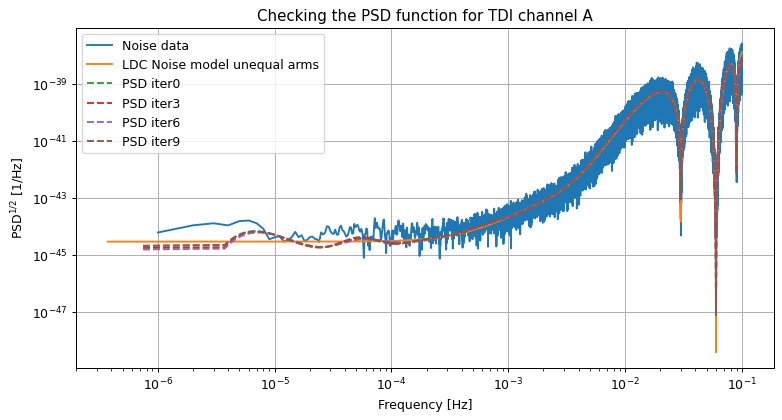

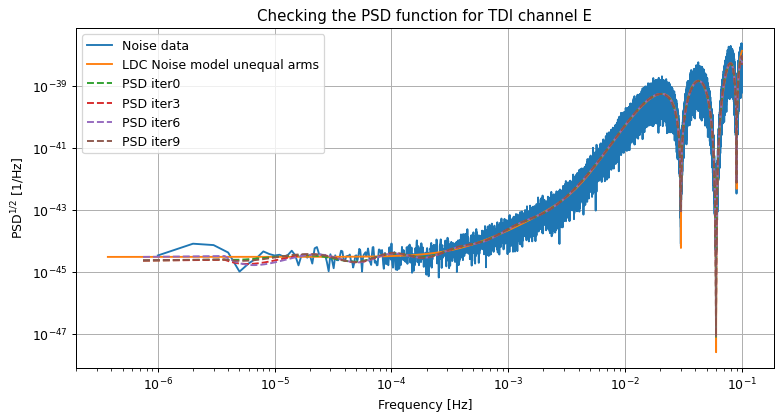

In [72]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'logratio_spline'
fit_dof = 15
k = 10
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))

## initialize imputation
for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    # plot PSD vs PSD-0 model
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # update imputation
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        # plot PSD vs PSD-fit models for every iteration
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

    ax.legend(loc='best')
ax.grid()
ax.grid()

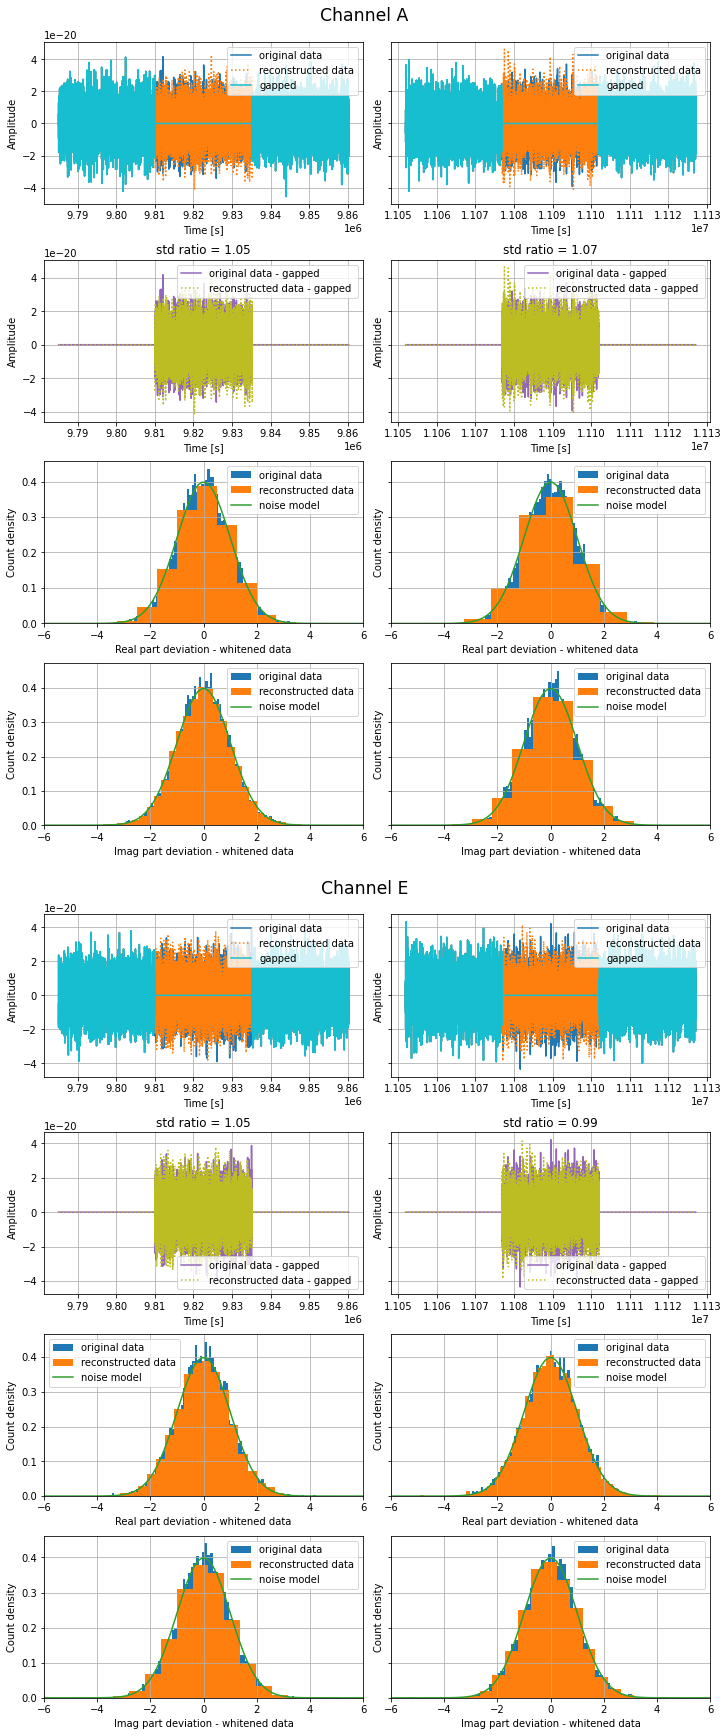

In [73]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

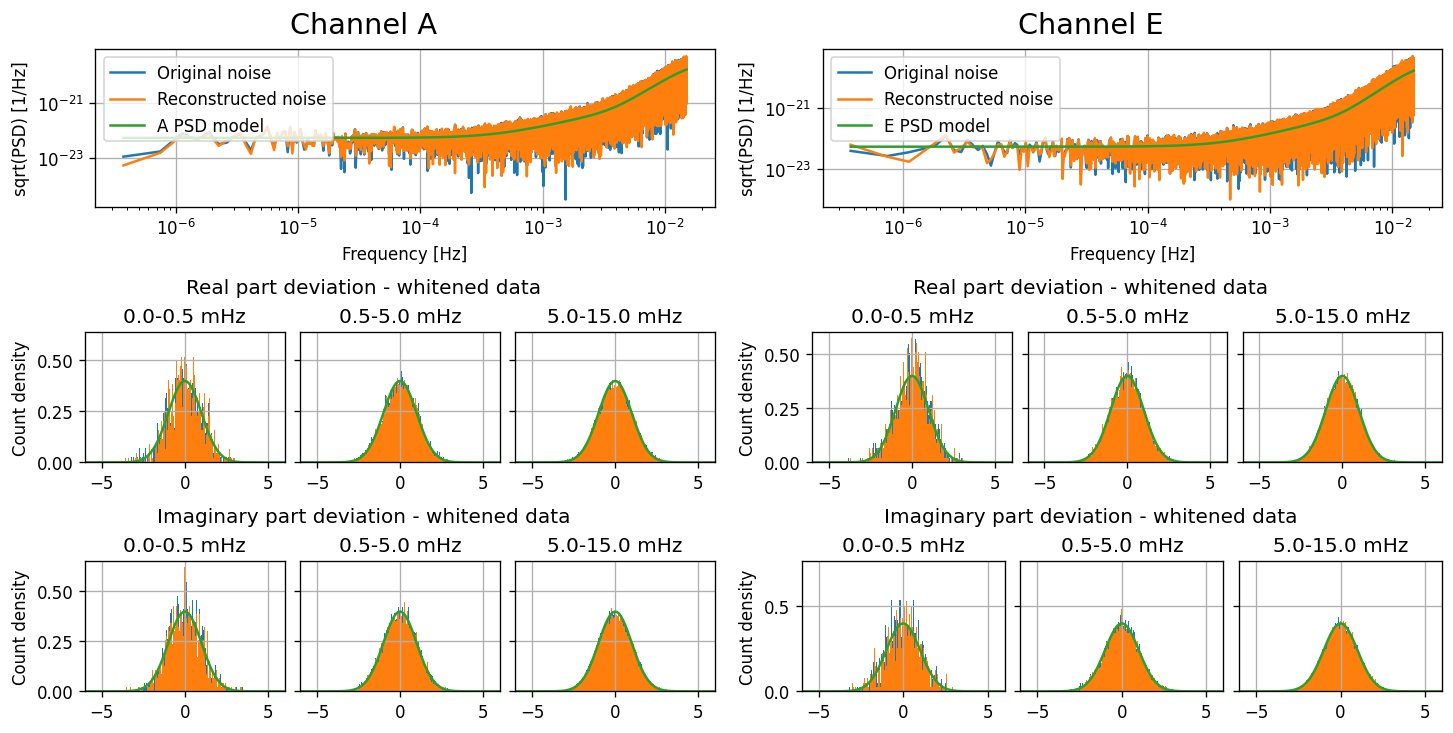

In [74]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)

#### Test 4: `fit_dof = 30`, `k_fmin = 30`, `n_iter = 10`

In [ ]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
datang_rec = np.rec.fromarrays([datang['t']]+3*[np.zeros(len(datang['t']))], 
                               names = datang.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzmask['mask']
n_iter = 10
fit_type = 'logratio_spline'
fit_dof = 30
k = 30
fmin_fit = 1 / tobs * k
print(' `fmin` value is {:.2e}'.format(fmin))

## initialize imputation
for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(datang, tdi, mask, noise_model = 'spritz')
    datang_rec[tdi] = y_res
    # plot PSD vs PSD-0 model
    fig, ax = plt.subplots(1, 1, figsize=(10,5),dpi=90)
    ax.set_title(r"Checking the PSD function for TDI channel "+tdi)
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    ax.loglog(psddatang['f'], (psddatang[tdi]), label="Noise data")
    ax.loglog(psd_cls.f[psd_cls.f>0], psd_cls.psd_fn(psd_cls.f[psd_cls.f>0]), label="LDC Noise model unequal arms")
    ax.grid()
    # update imputation
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = datang_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin_fit)
        datang_rec[tdi] = y_res
        # plot PSD vs PSD-fit models for every iteration
        if (i % 3)==0:
            ax.loglog(psdmod.f[psdmod.f>fmin], (psdmod.psd_fn(psdmod.f[psdmod.f>fmin])), ls='--', label="PSD iter"+str(i))
            ax.legend(loc='upper left')
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))

    ax.legend(loc='best')
ax.grid()
ax.grid()

 `fmin` value is 3.75e-07
Computation of autocovariance + PSD took 7.48183798789978
Computation of autocovariance + PSD took 0.2838878631591797
Computation of autocovariance + PSD took 0.26644396781921387
Computation of autocovariance + PSD took 0.2553541660308838
Computation of autocovariance + PSD took 0.24967002868652344
Computation of autocovariance + PSD took 0.25437021255493164
Computation of autocovariance + PSD took 0.23825502395629883
Computation of autocovariance + PSD took 0.23900294303894043
Computation of autocovariance + PSD took 0.25167202949523926
Computation of autocovariance + PSD took 0.25635790824890137


In [ ]:
view_gaps(ts = datan['t'],
          ys = [[datan[names] for names in datan.dtype.names[1:]], 
                [datang_rec[names] for names in datan.dtype.names[1:]]],
          yg = [datang[names] for names in datan.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'],
          labels=['original data', 'reconstructed data', 'gapped data'],
          save = False, fname = figname, nwing=5000)

In [ ]:
# plot comparison
plot_compare_spectra_timeseries(data = [datan, datang_rec], 
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Original noise', 'Reconstructed noise'], 
                                save = False, fname = figname)